In [51]:
import pandas as pd
from IPython.display import display, HTML
import numpy as np
from sklearn.utils import resample
from IPython.display import display
import numpy as np

# Create a connection with SQL server to get data.
def exec_sql_query(query, param=None):
    
    from sqlalchemy import create_engine
    import urllib
    params = urllib.parse.quote_plus("DRIVER={SQL Server Native Client 11.0};SERVER=LAPTOP-C3LFVOFI;DATABASE=student_life;UID=student_sense;PWD=abhinav123")
    engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)
    connection = engine.raw_connection()
    
    try:
        cursor = connection.cursor()
        if(param):
            cursor.execute(query, param)
        else : 
            cursor.execute(query)
            
        results = cursor.fetchall()
        columns = [column[0] for column in cursor.description]
        df = pd.DataFrame.from_records(results, columns=columns)
        cursor.close()
        connection.commit()
    finally:
        connection.close()
    
    del engine
    return df

In [52]:
# Fetching EMA data from SQL.
sql = "Exec get_avg_stress_levels"
stress_level = exec_sql_query(sql)
stress_level.date = pd.to_datetime(stress_level.date) 

C:\Users\Abhinav Shaw\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
C:\Users\Abhinav Shaw\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
C:\Users\Abhinav Shaw\Anaconda3\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


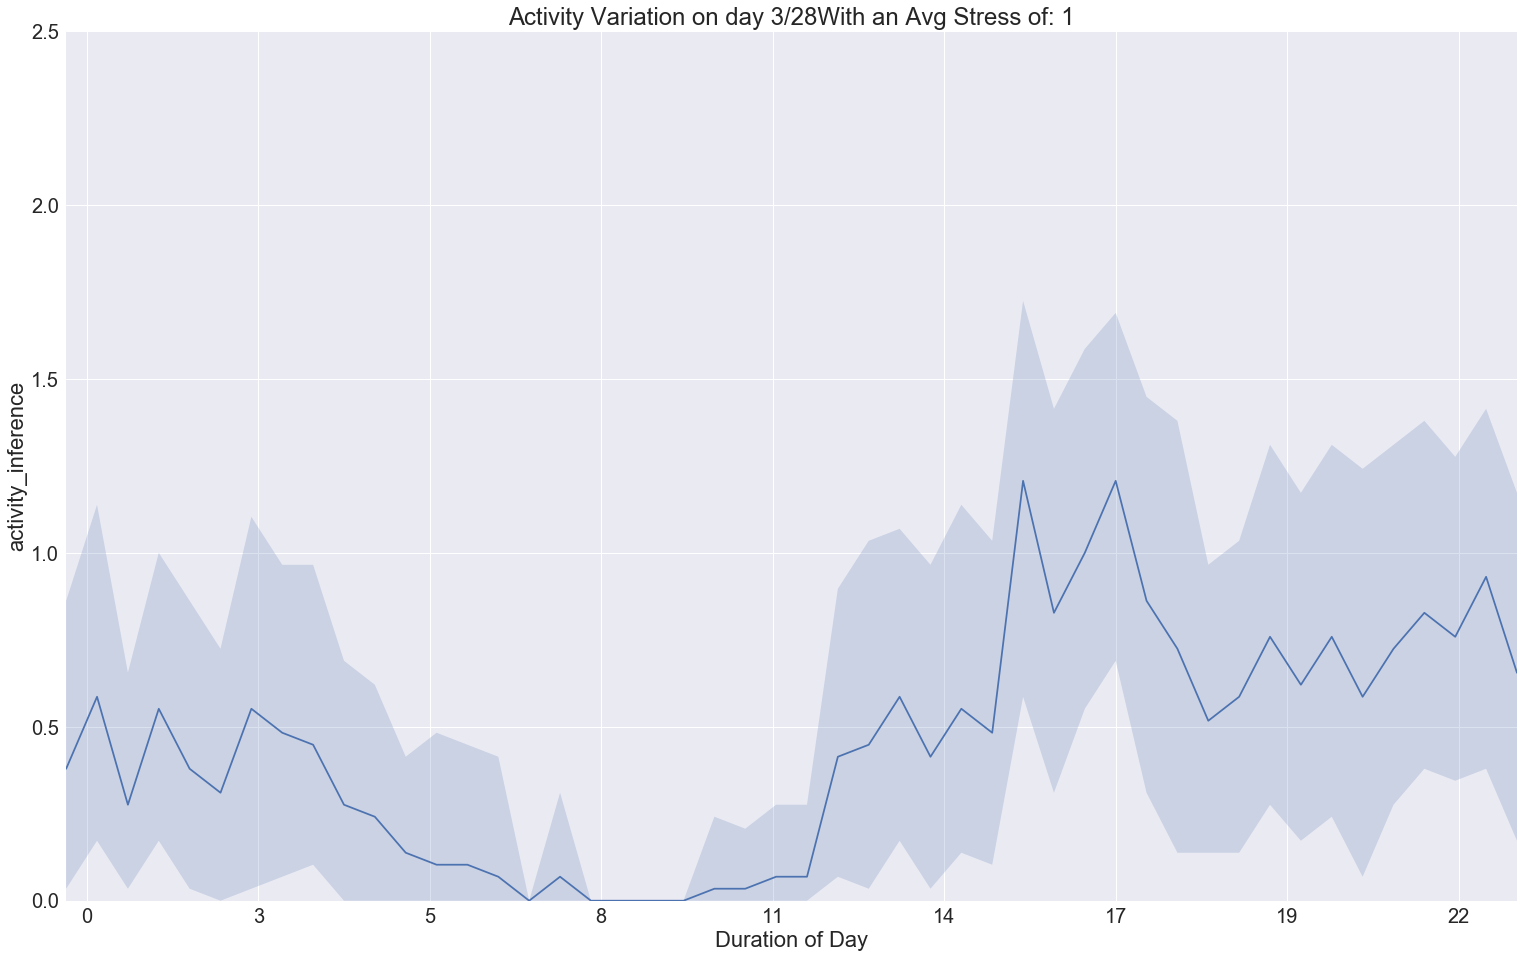

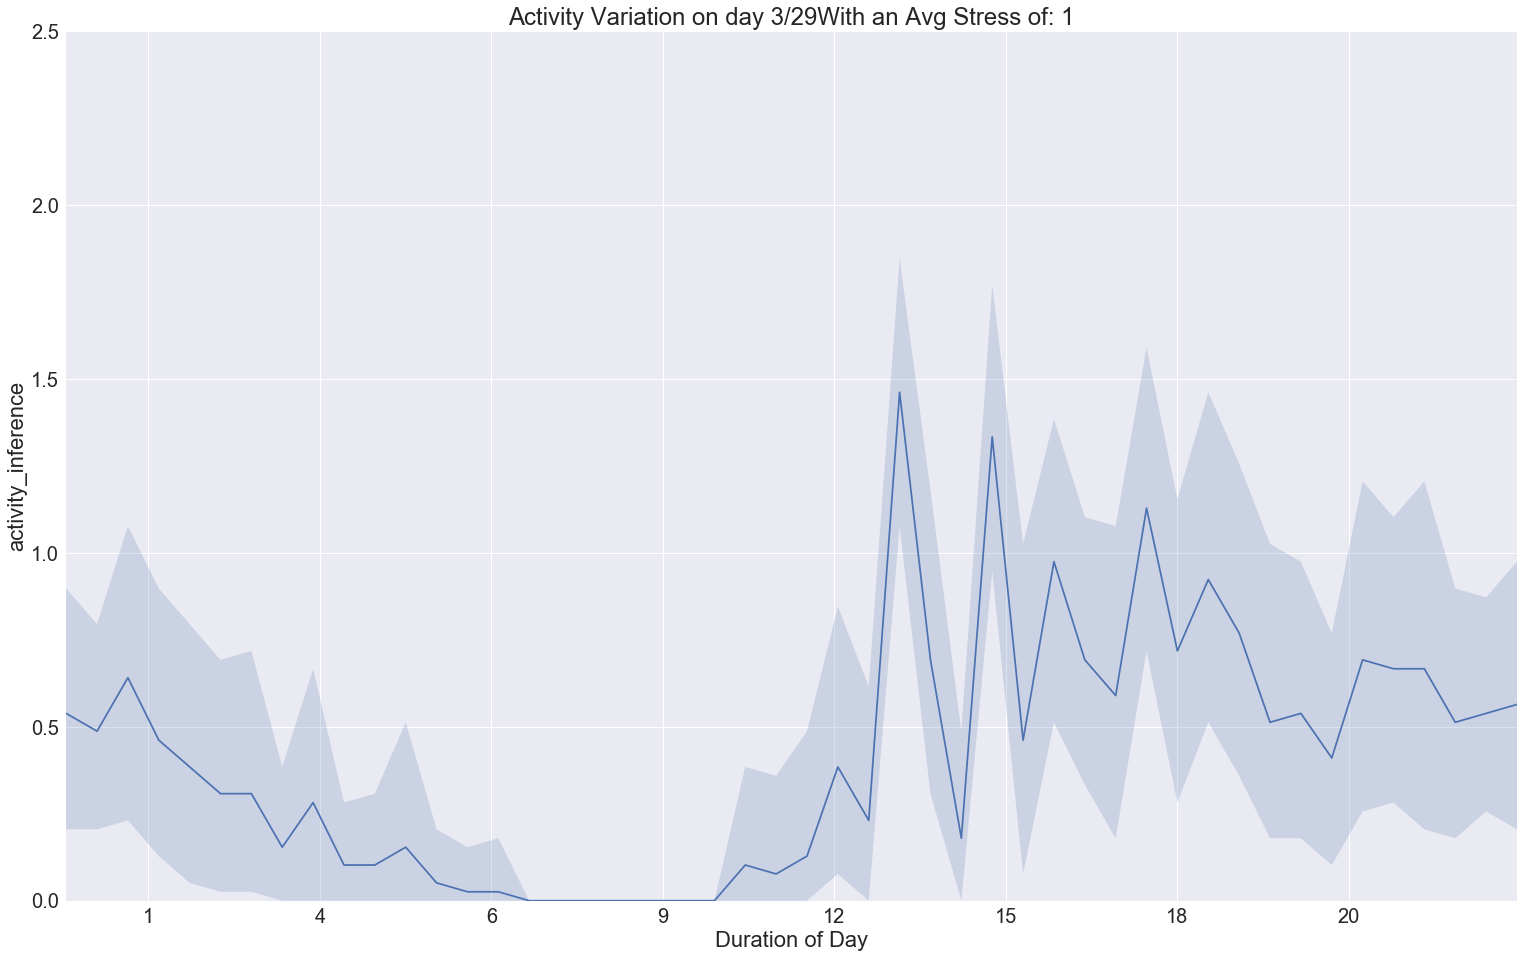

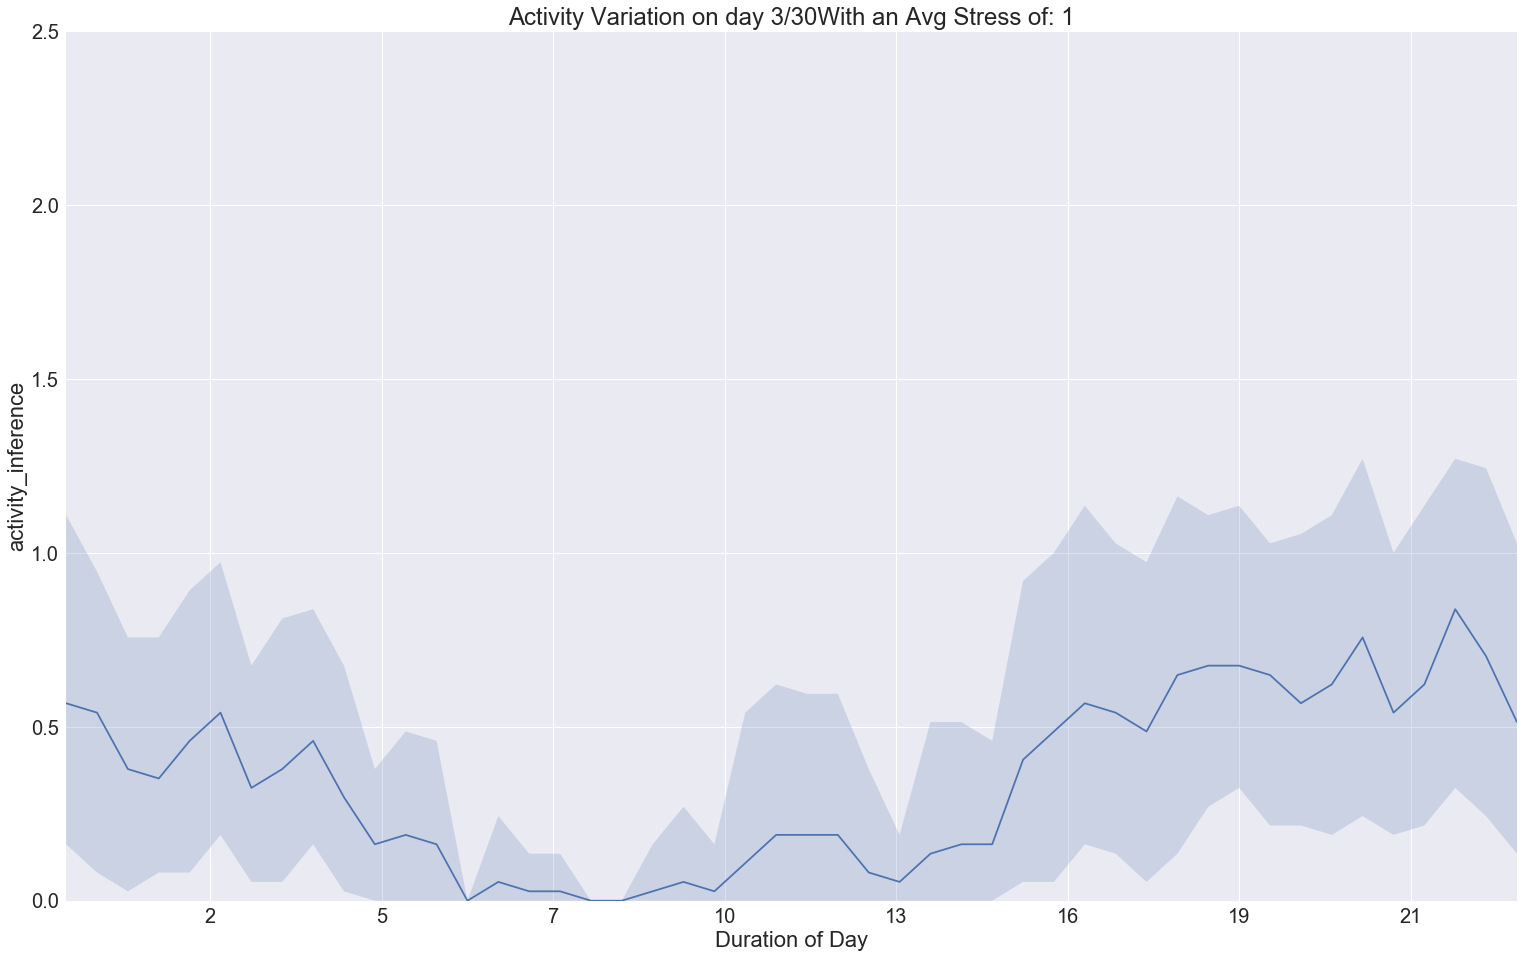

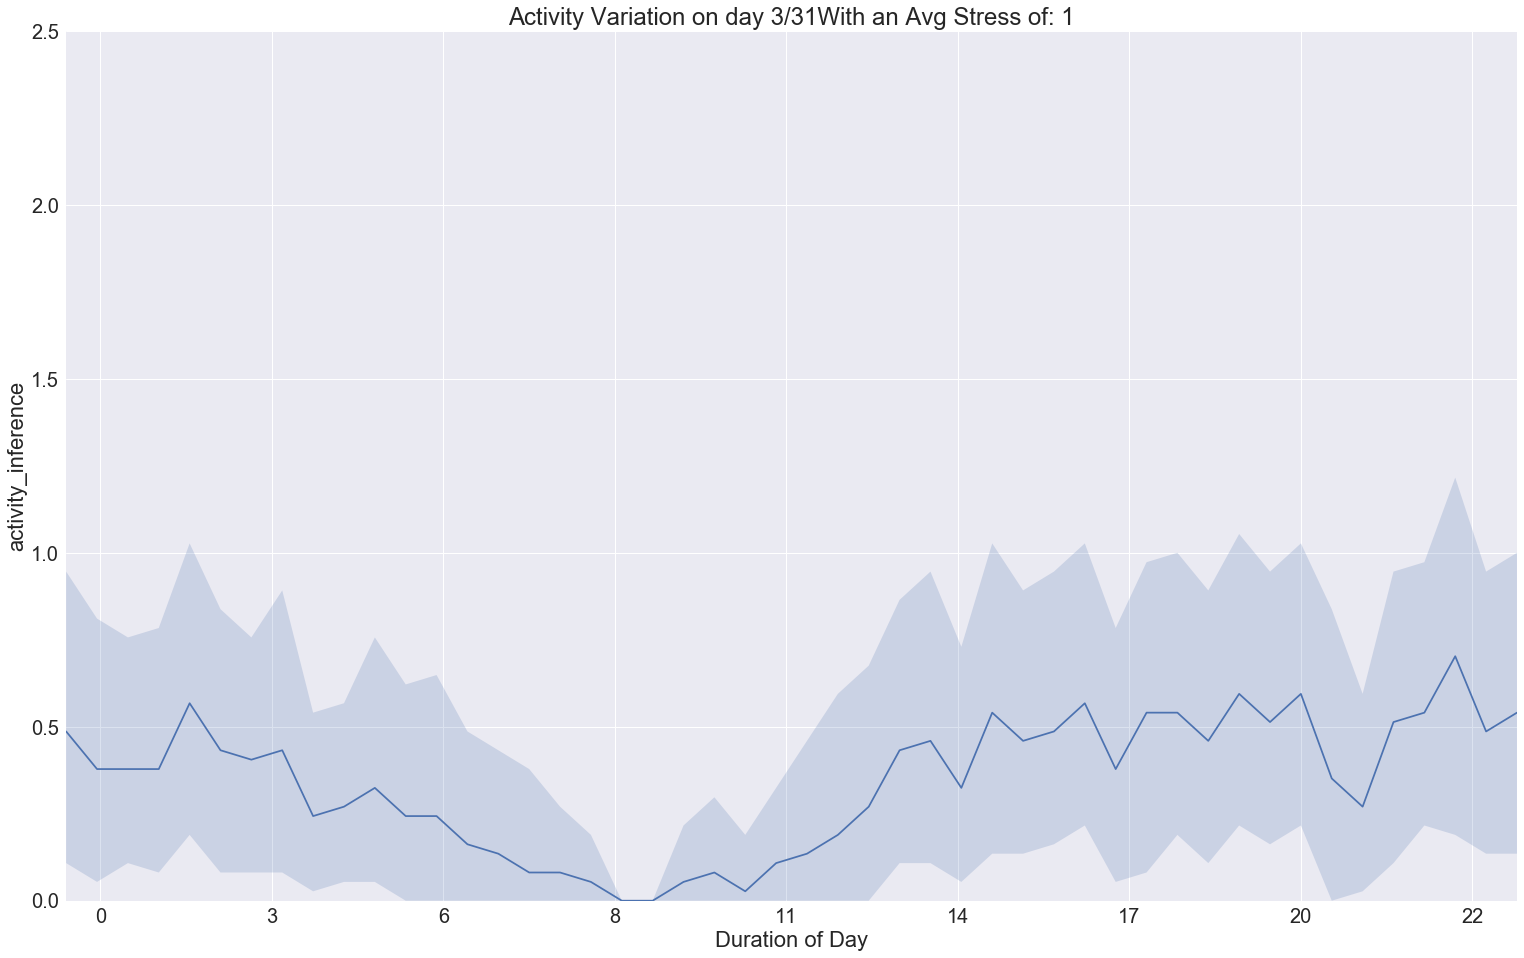

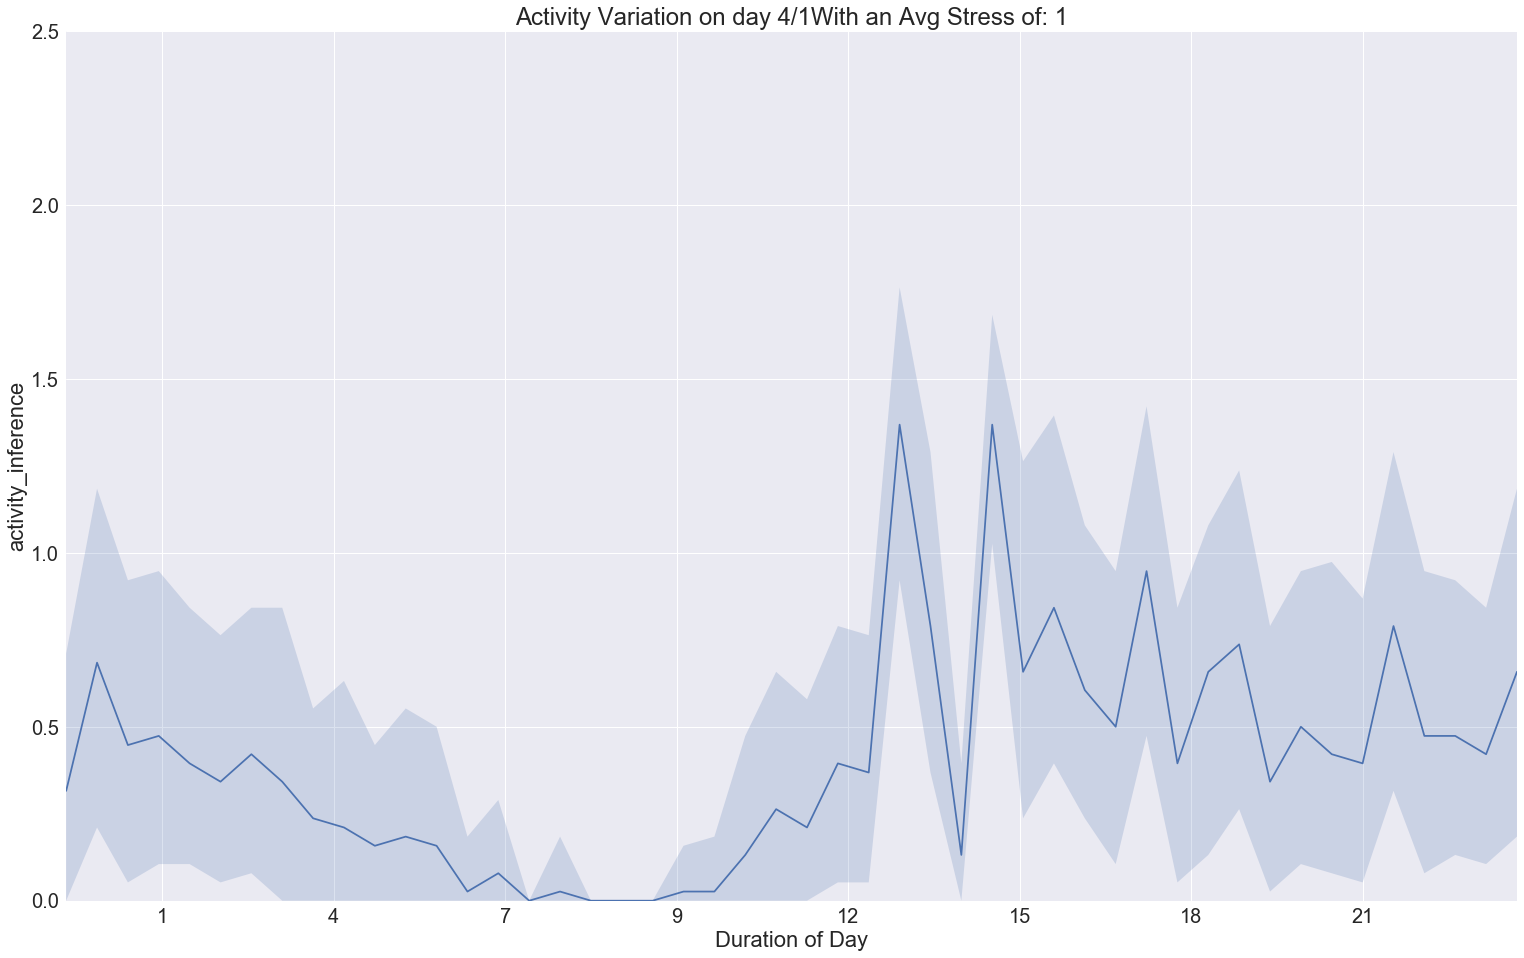

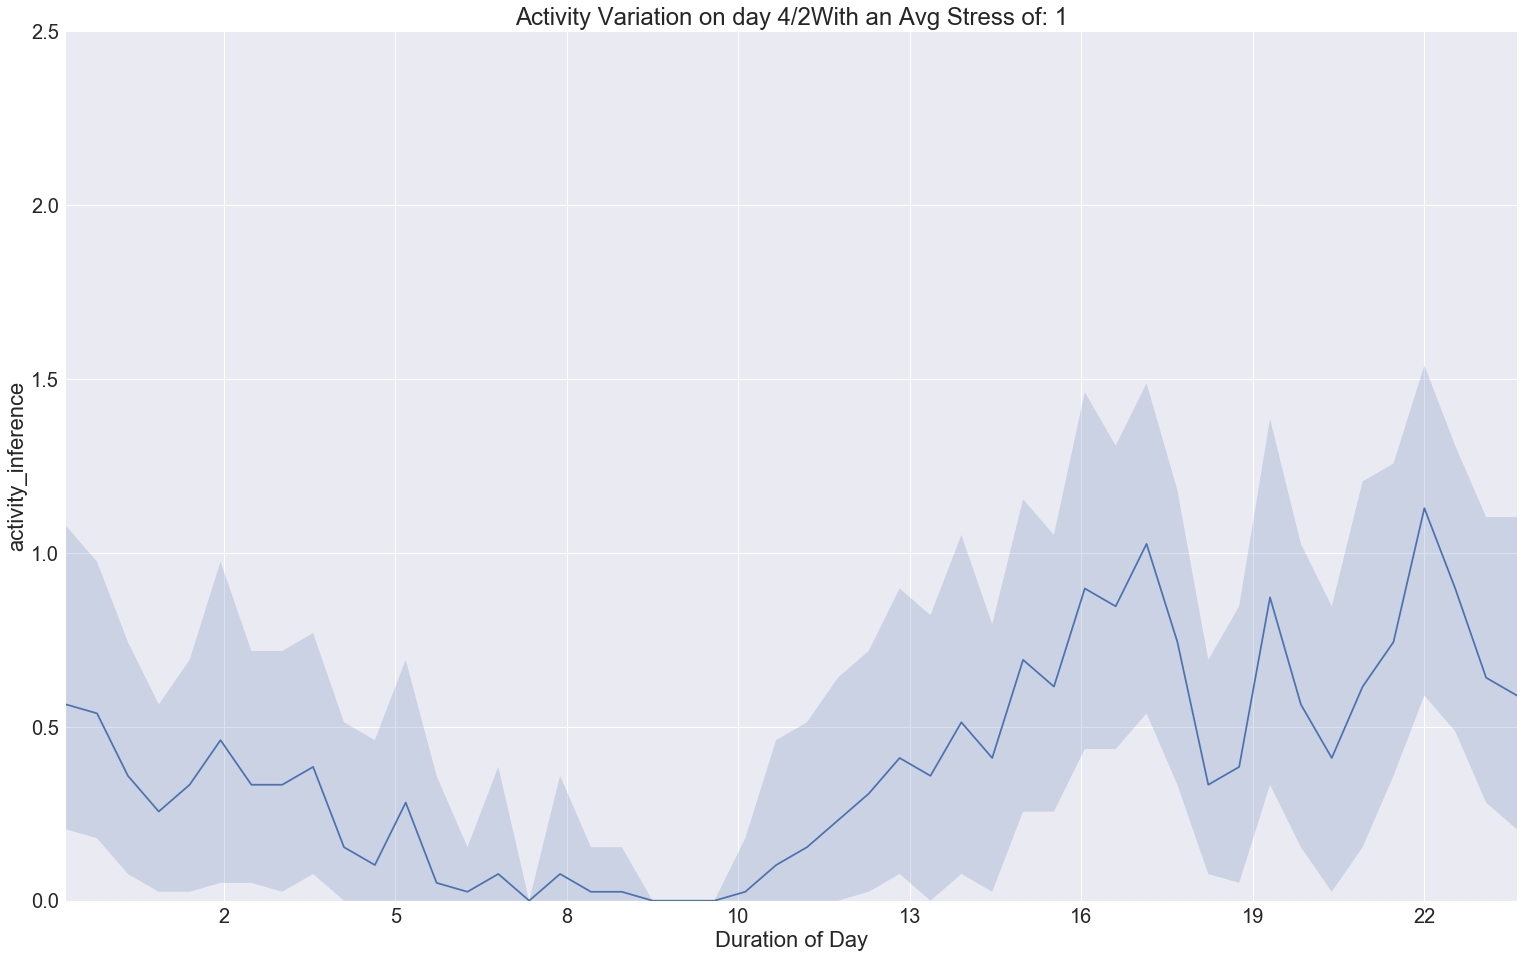

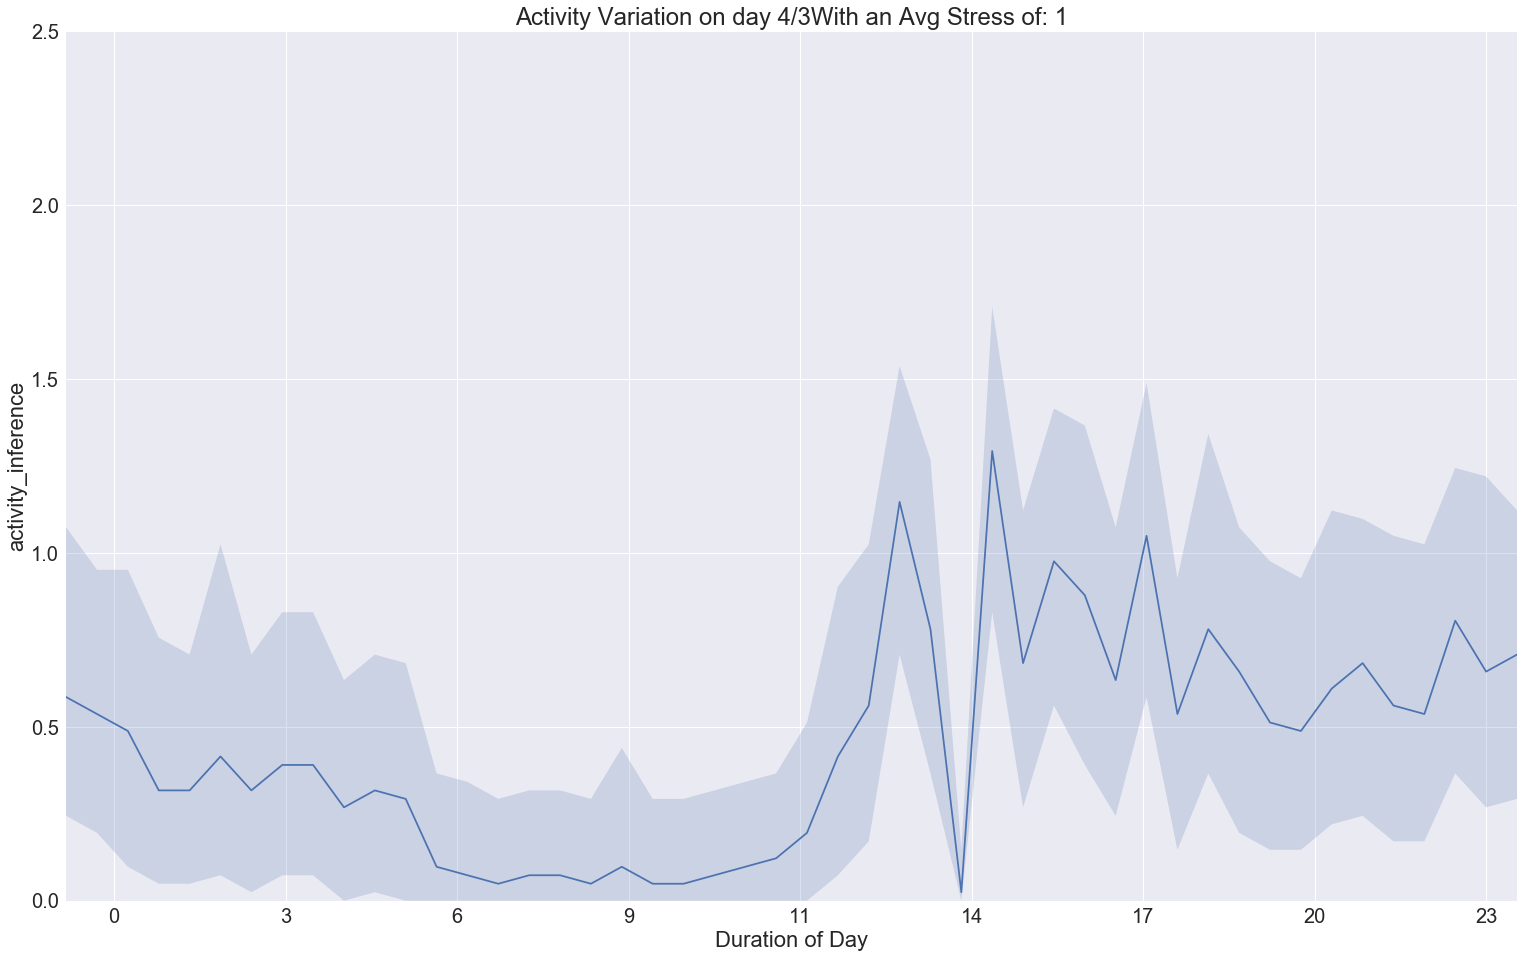

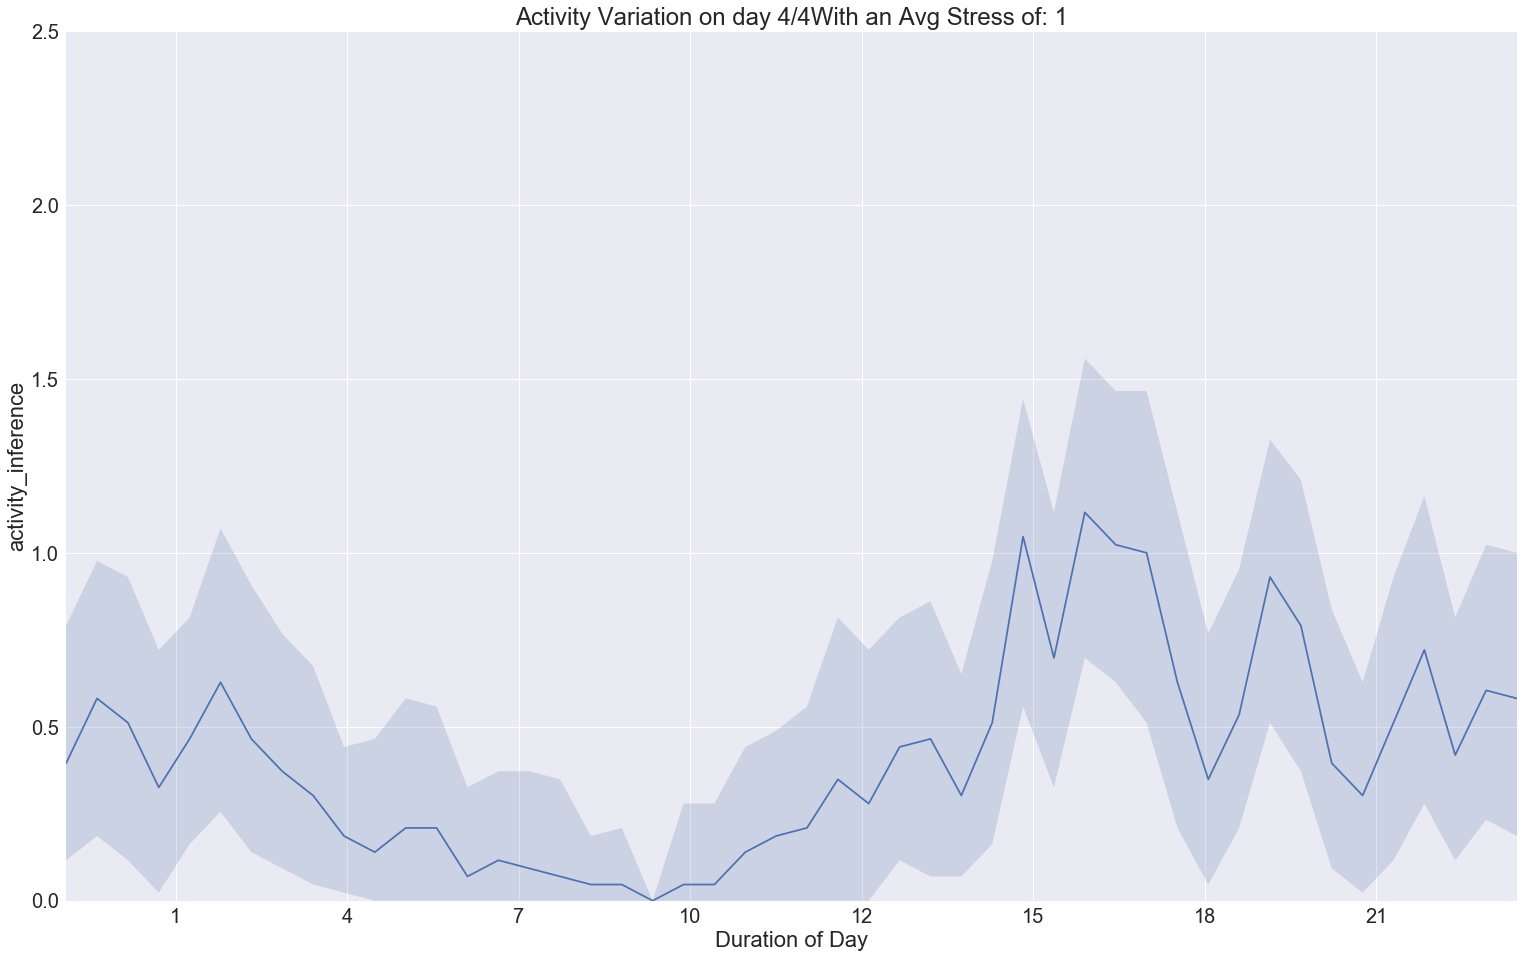

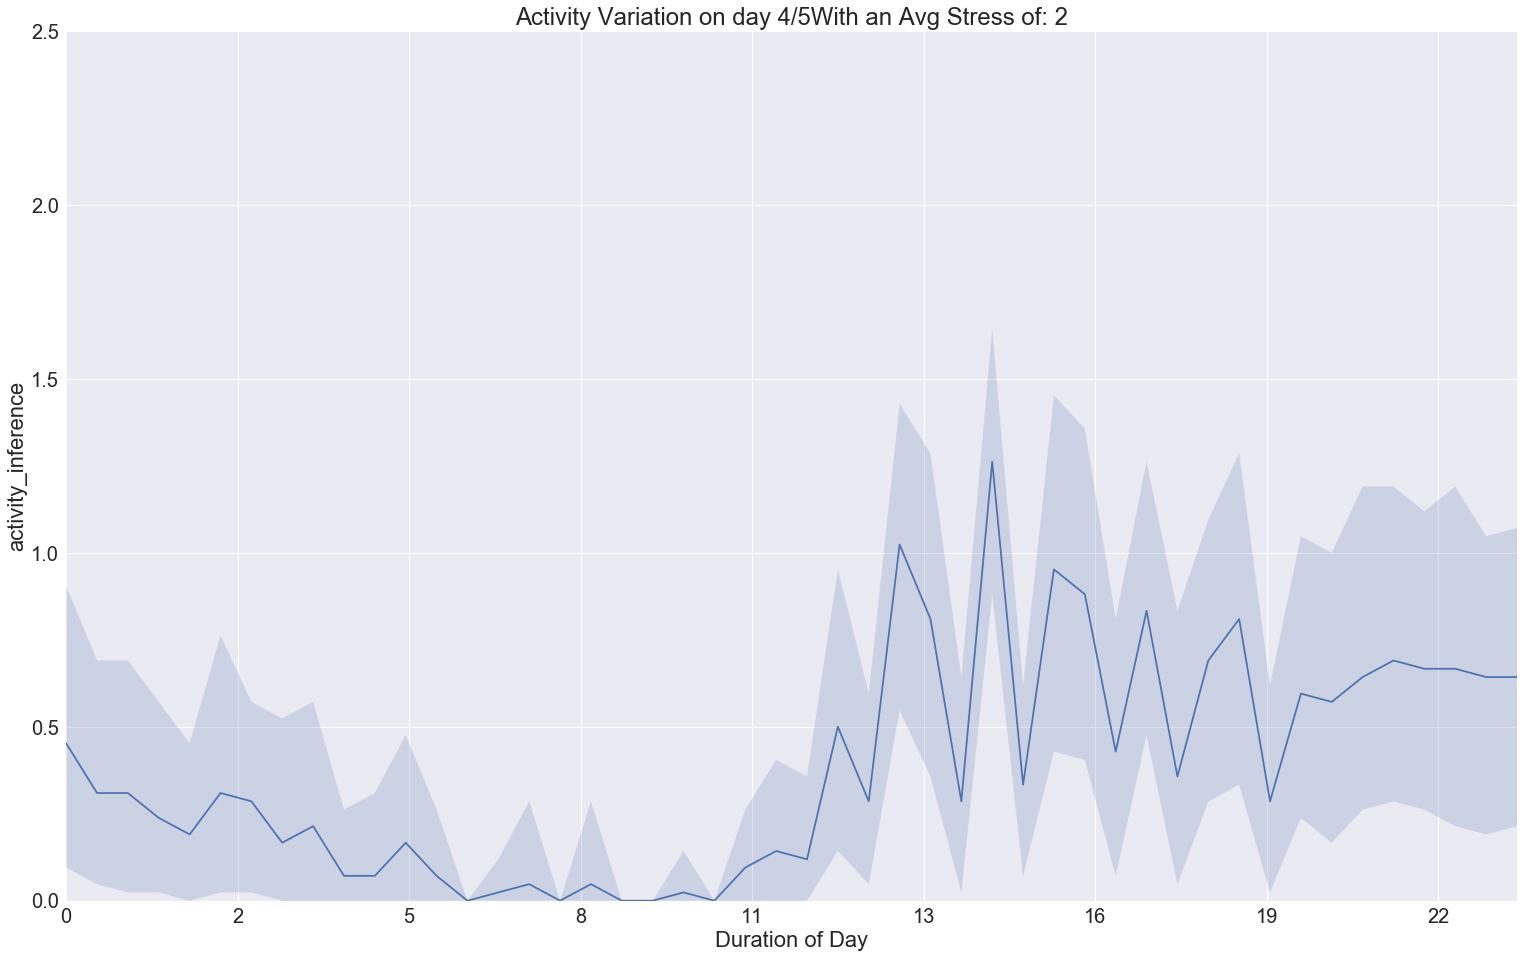

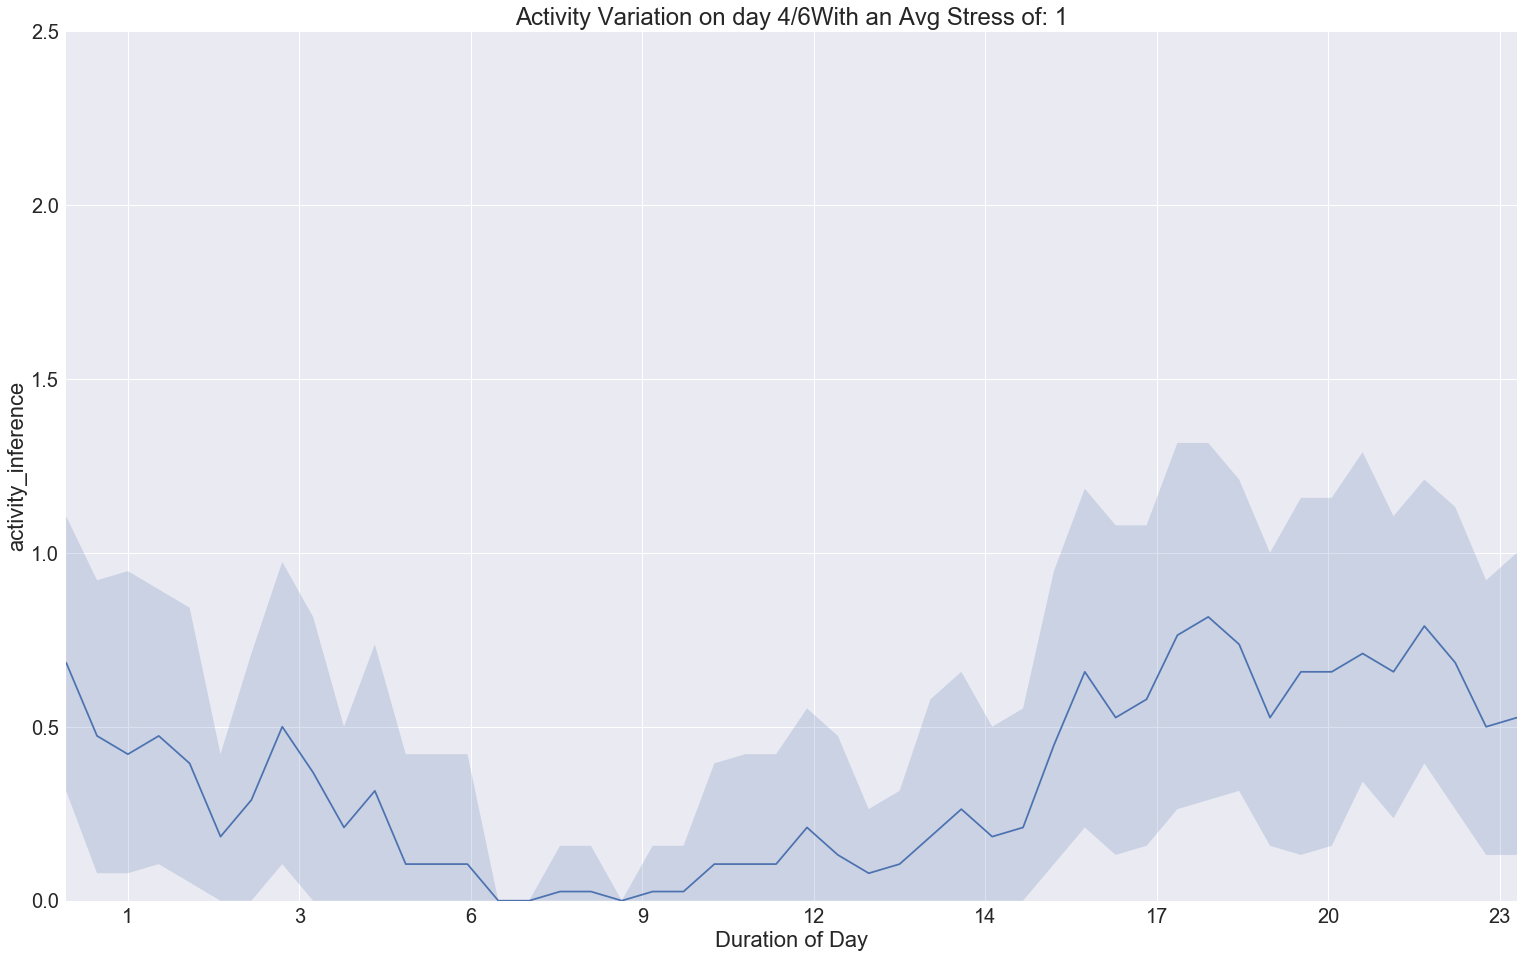

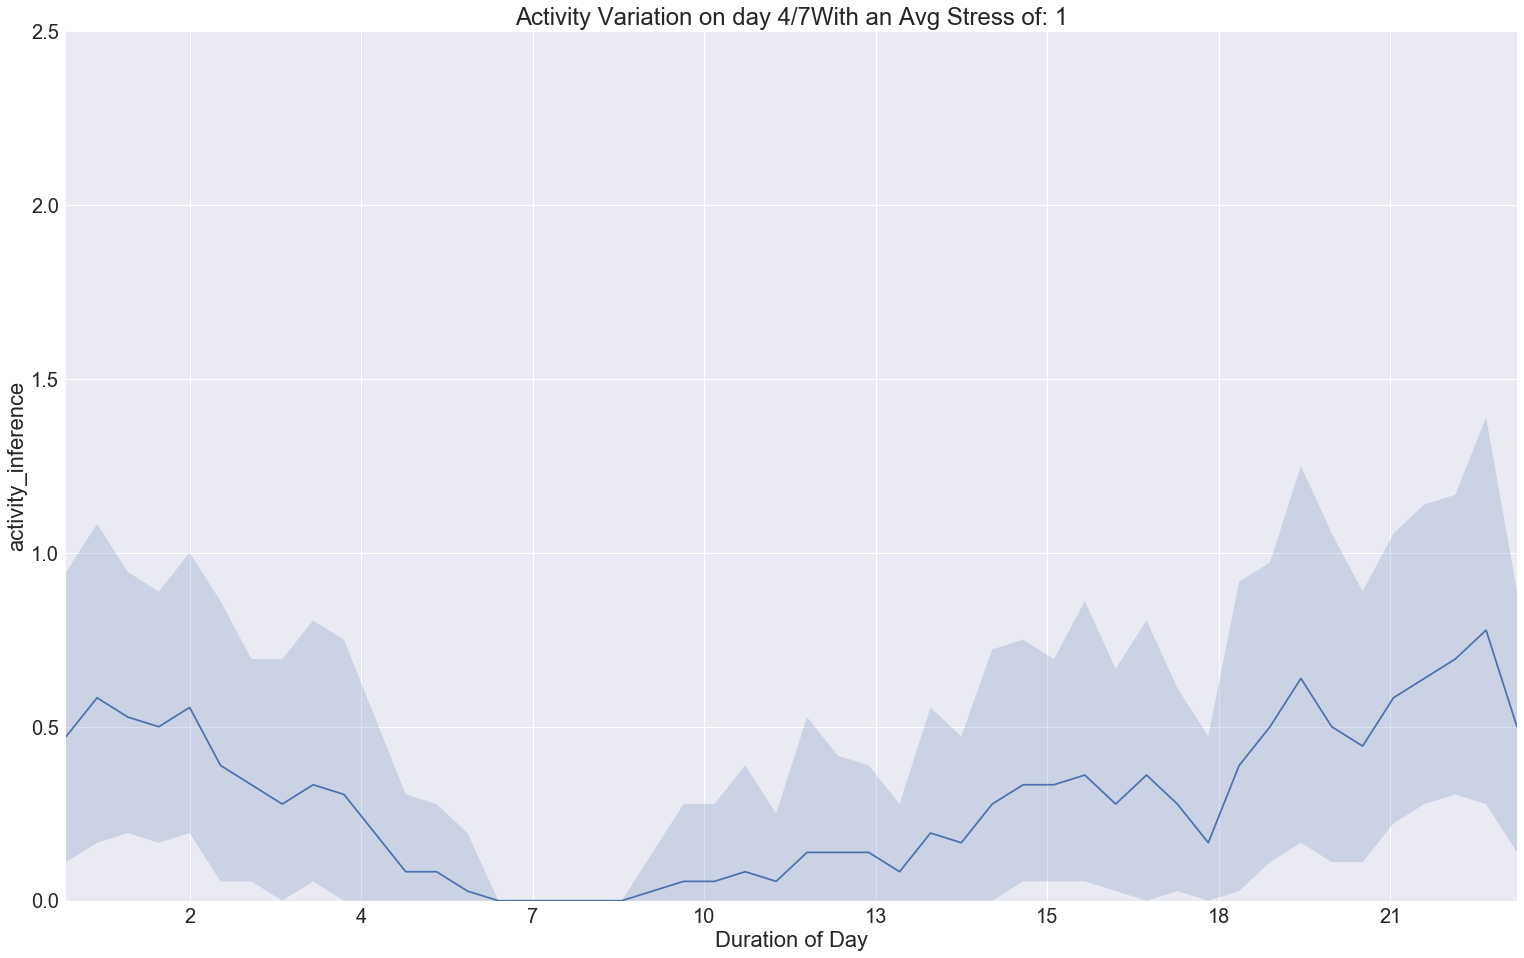

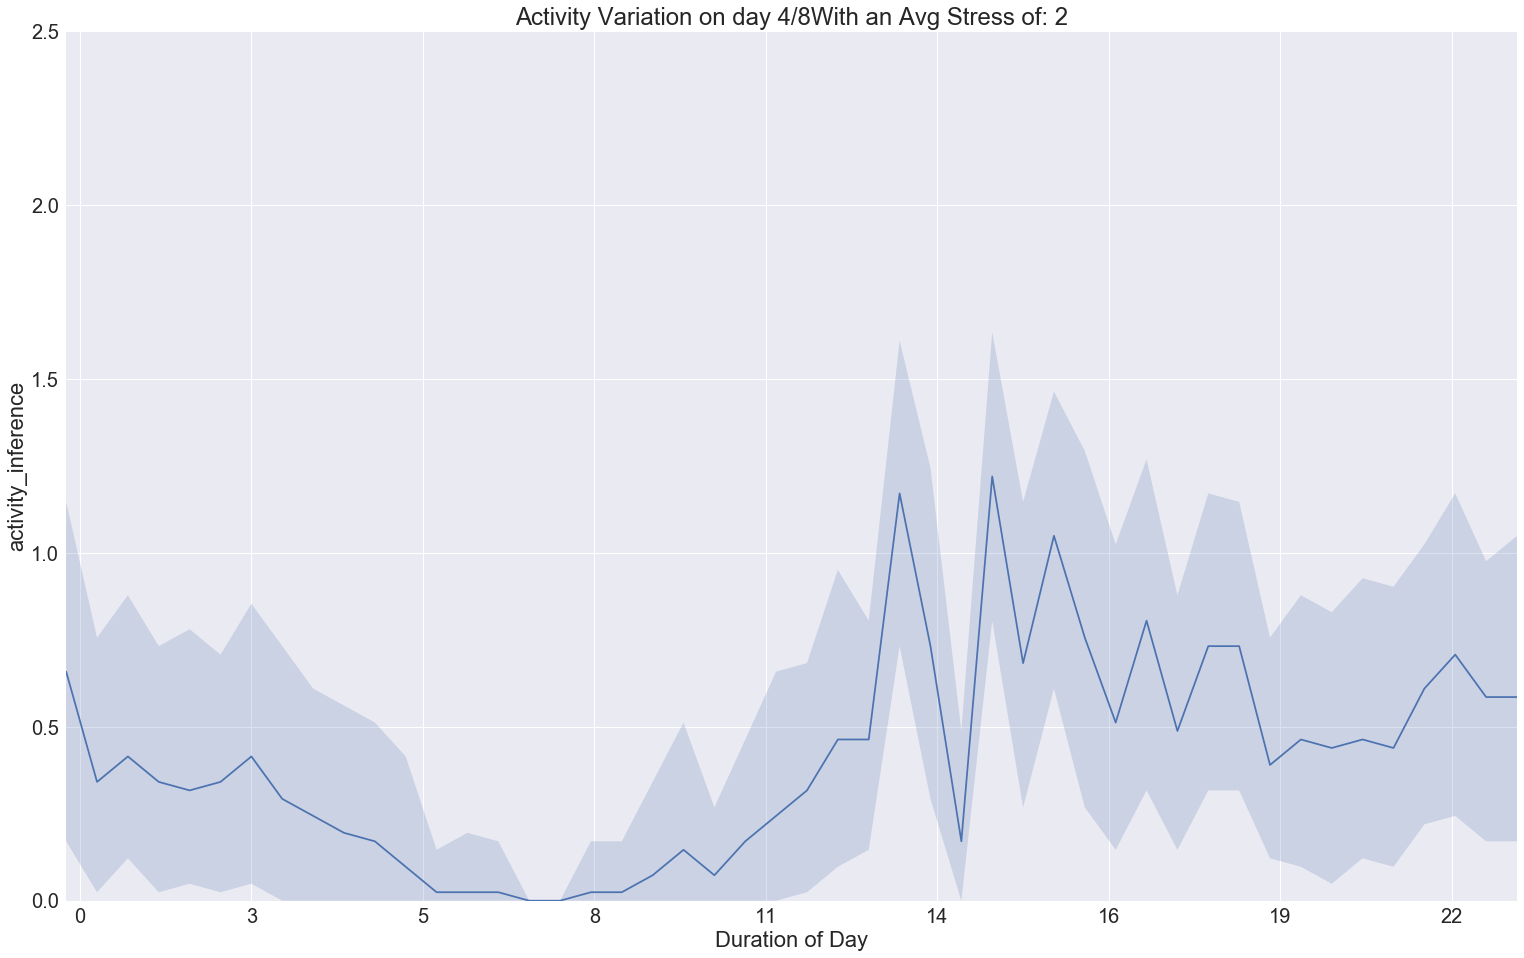

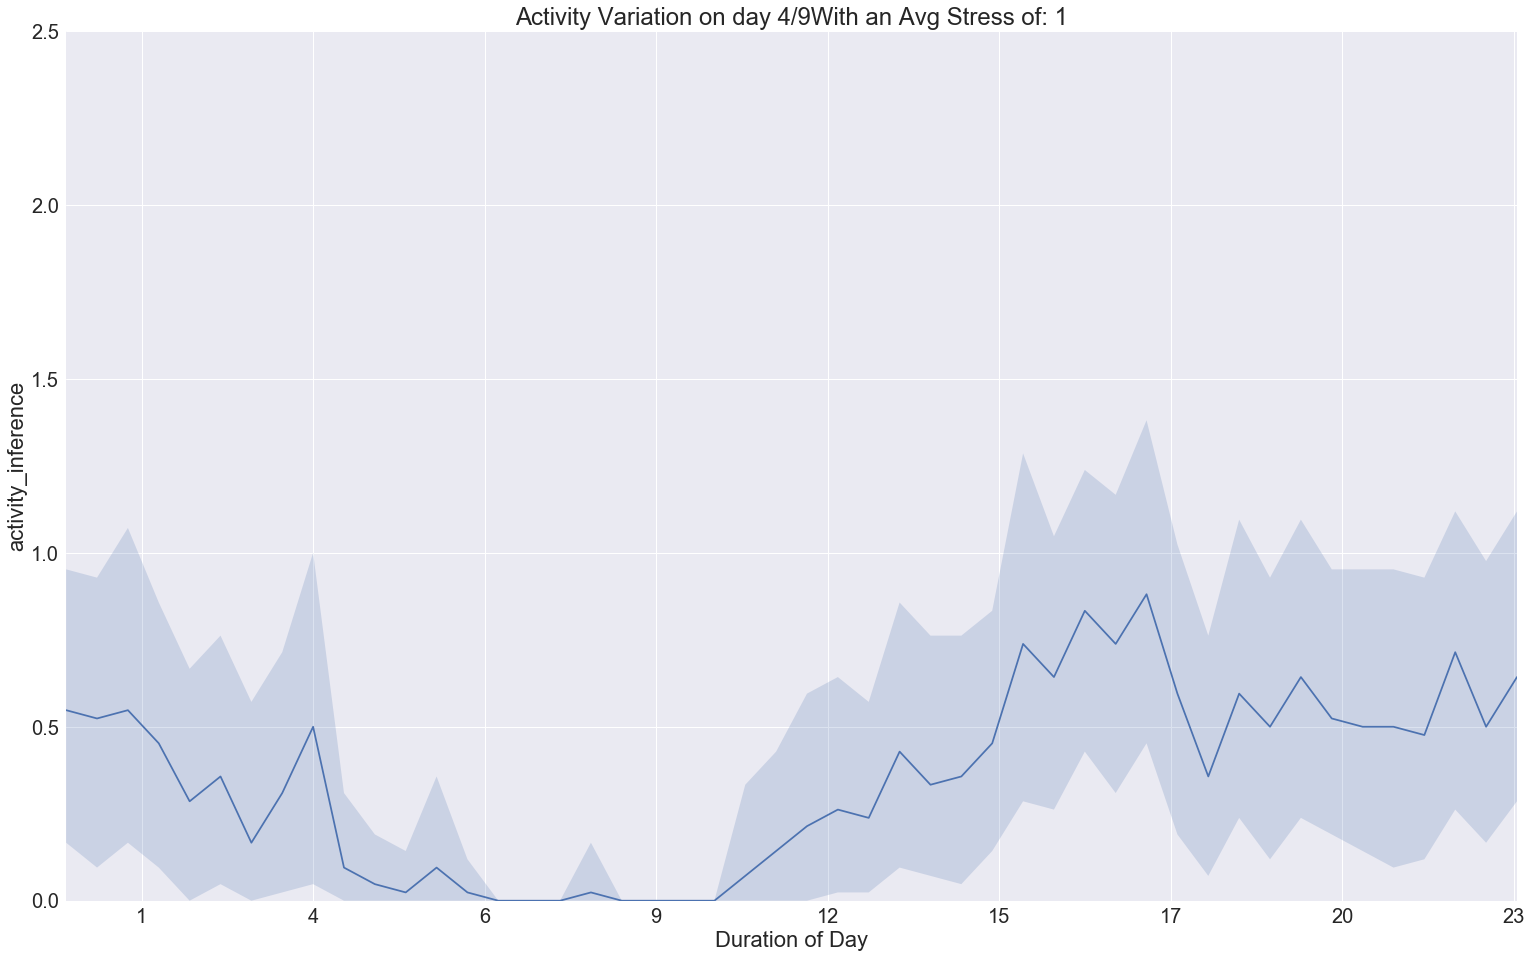

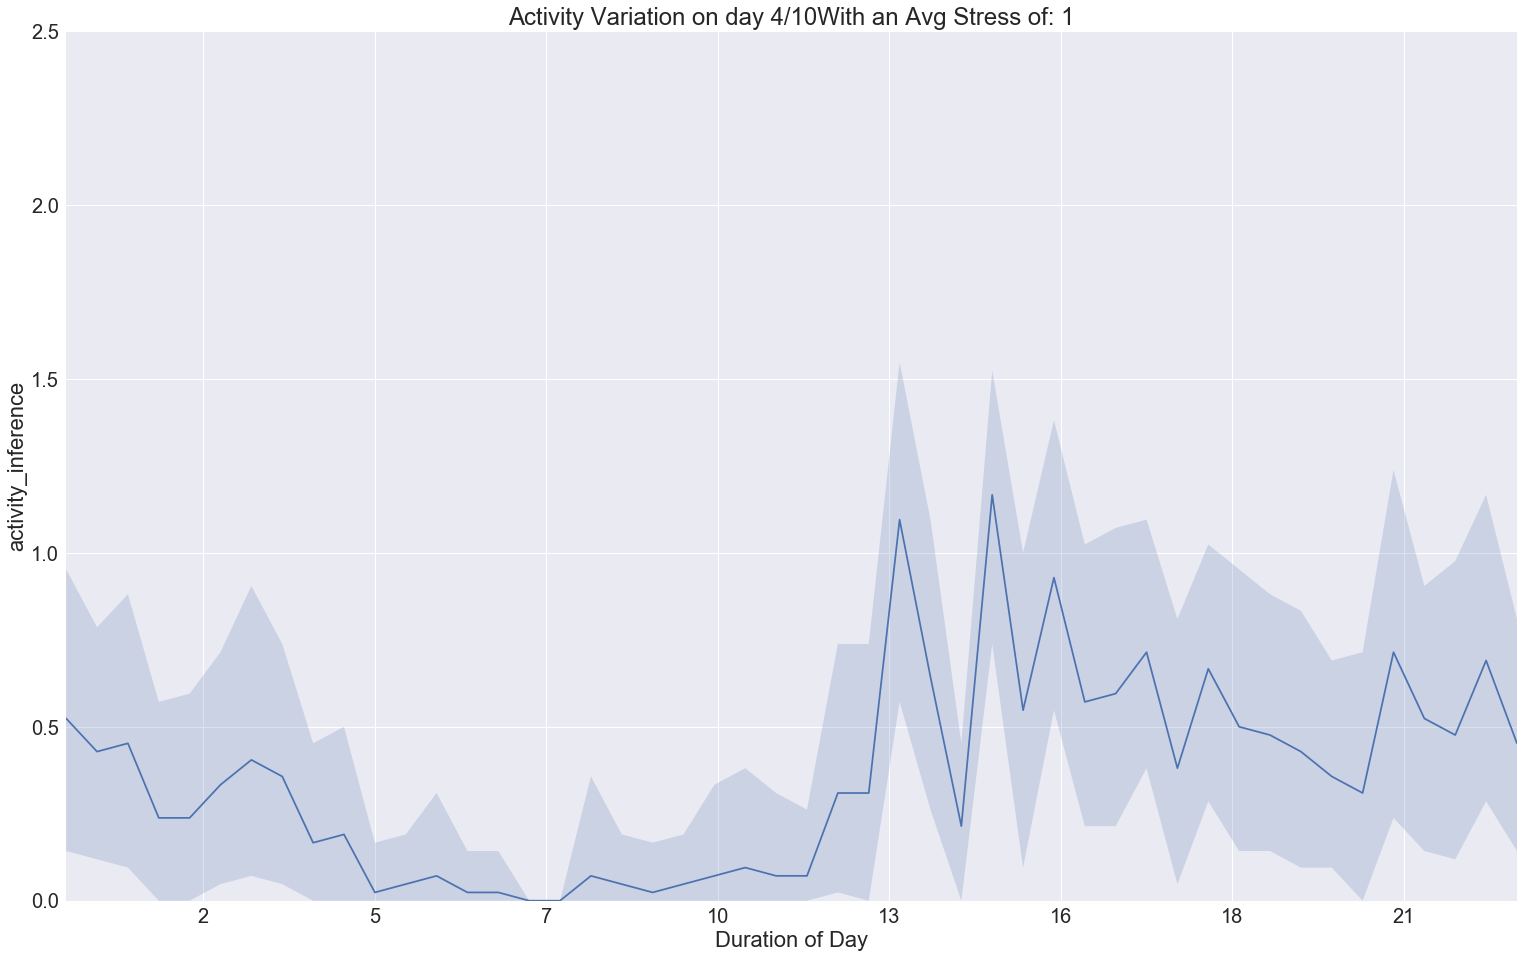

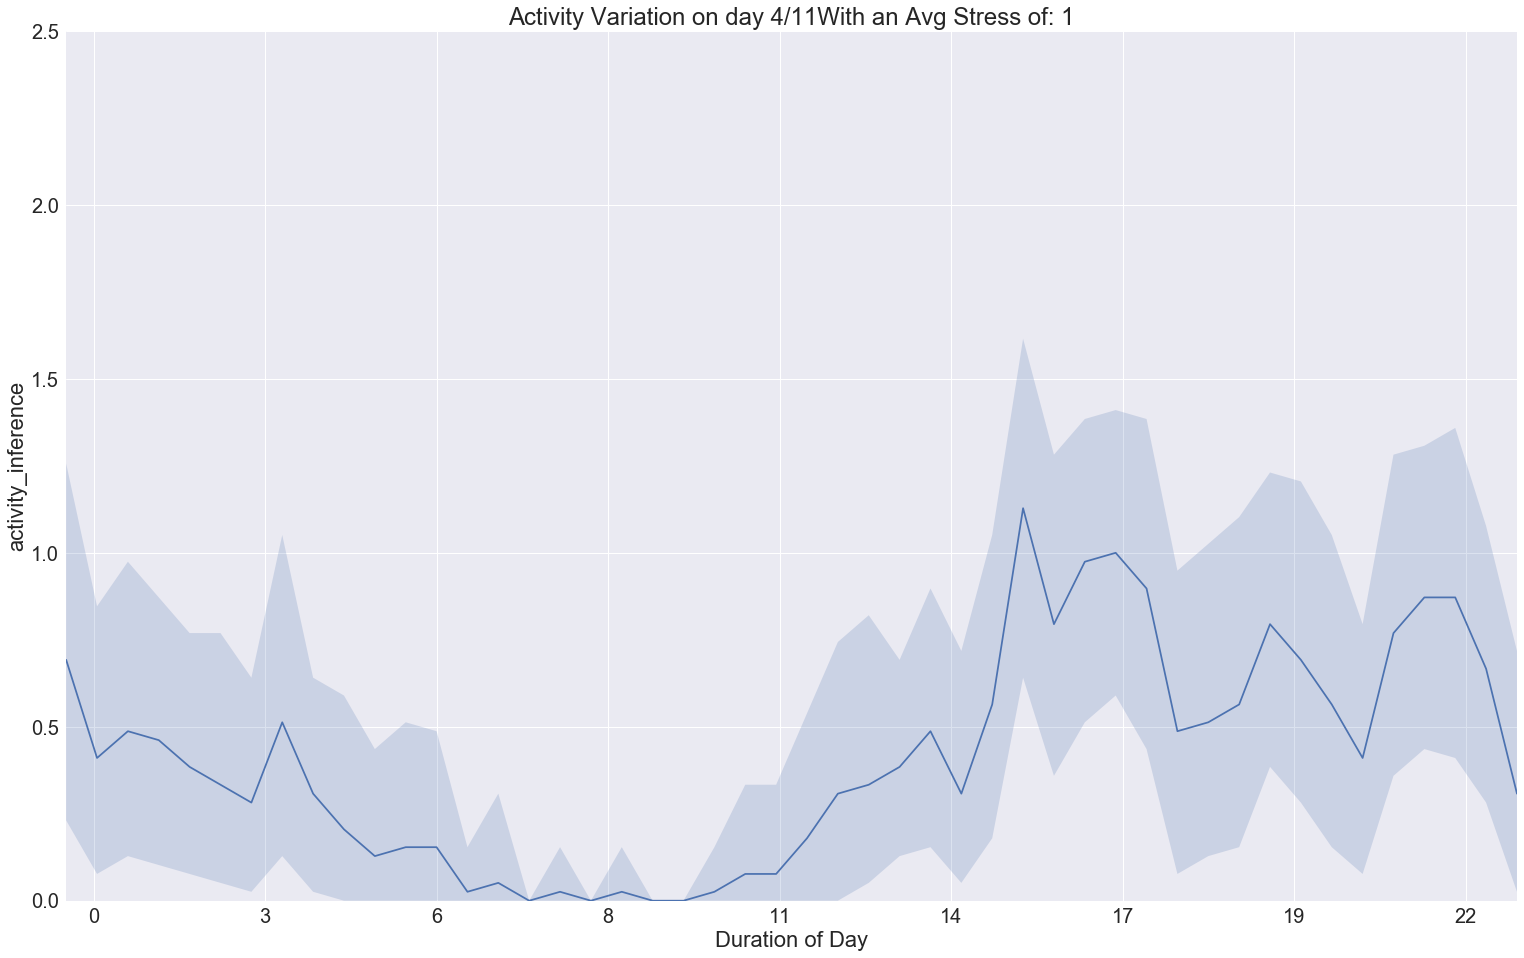

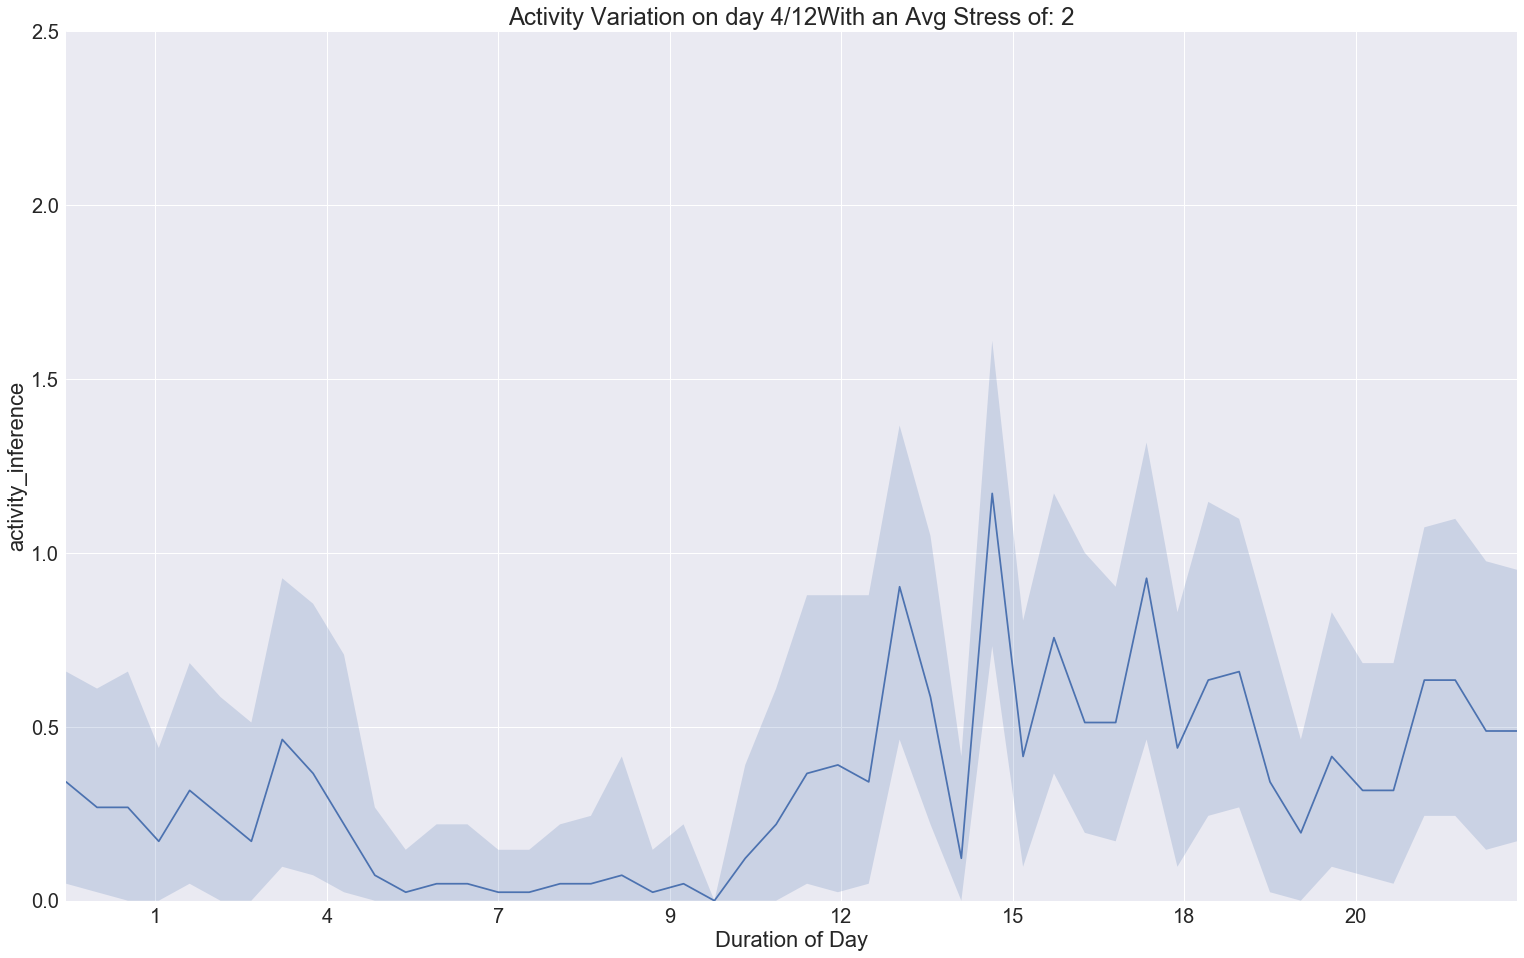

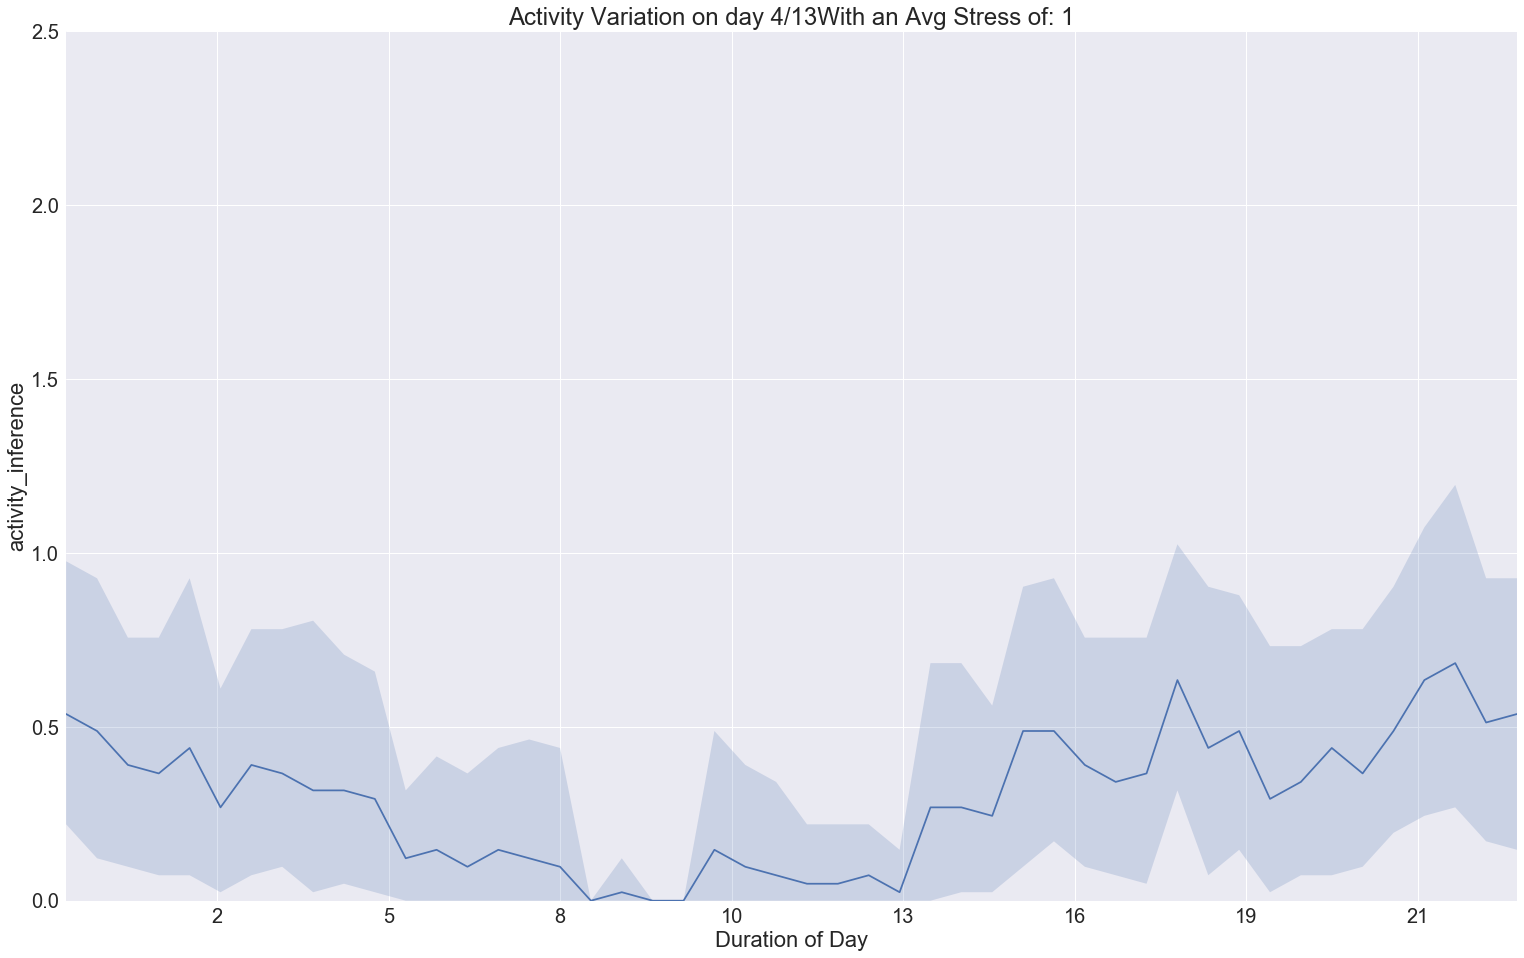

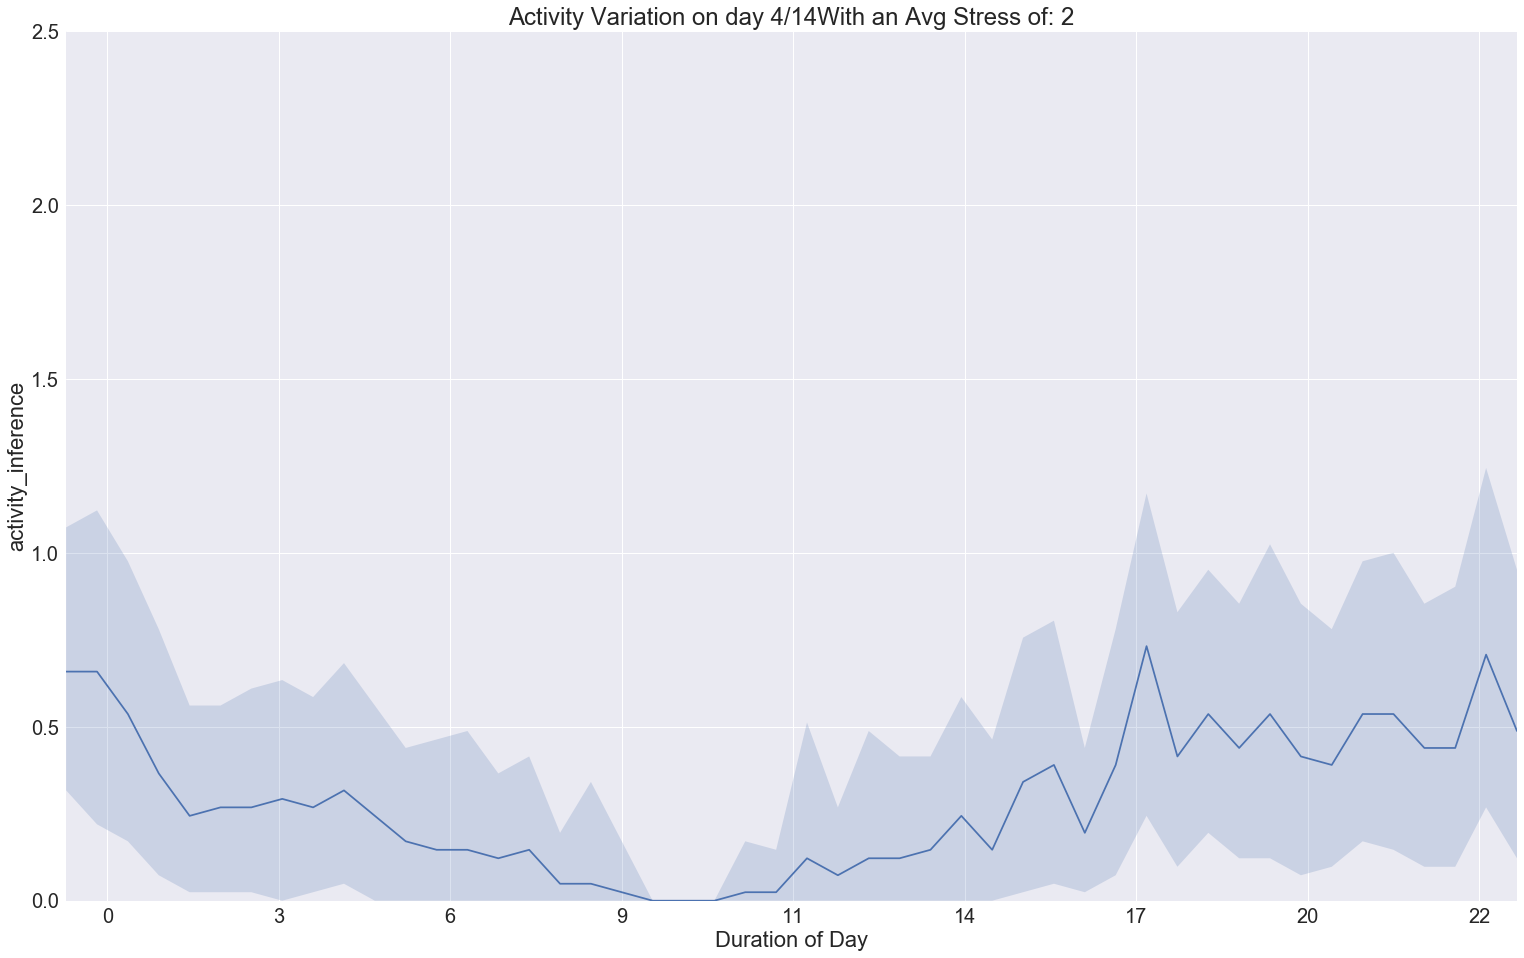

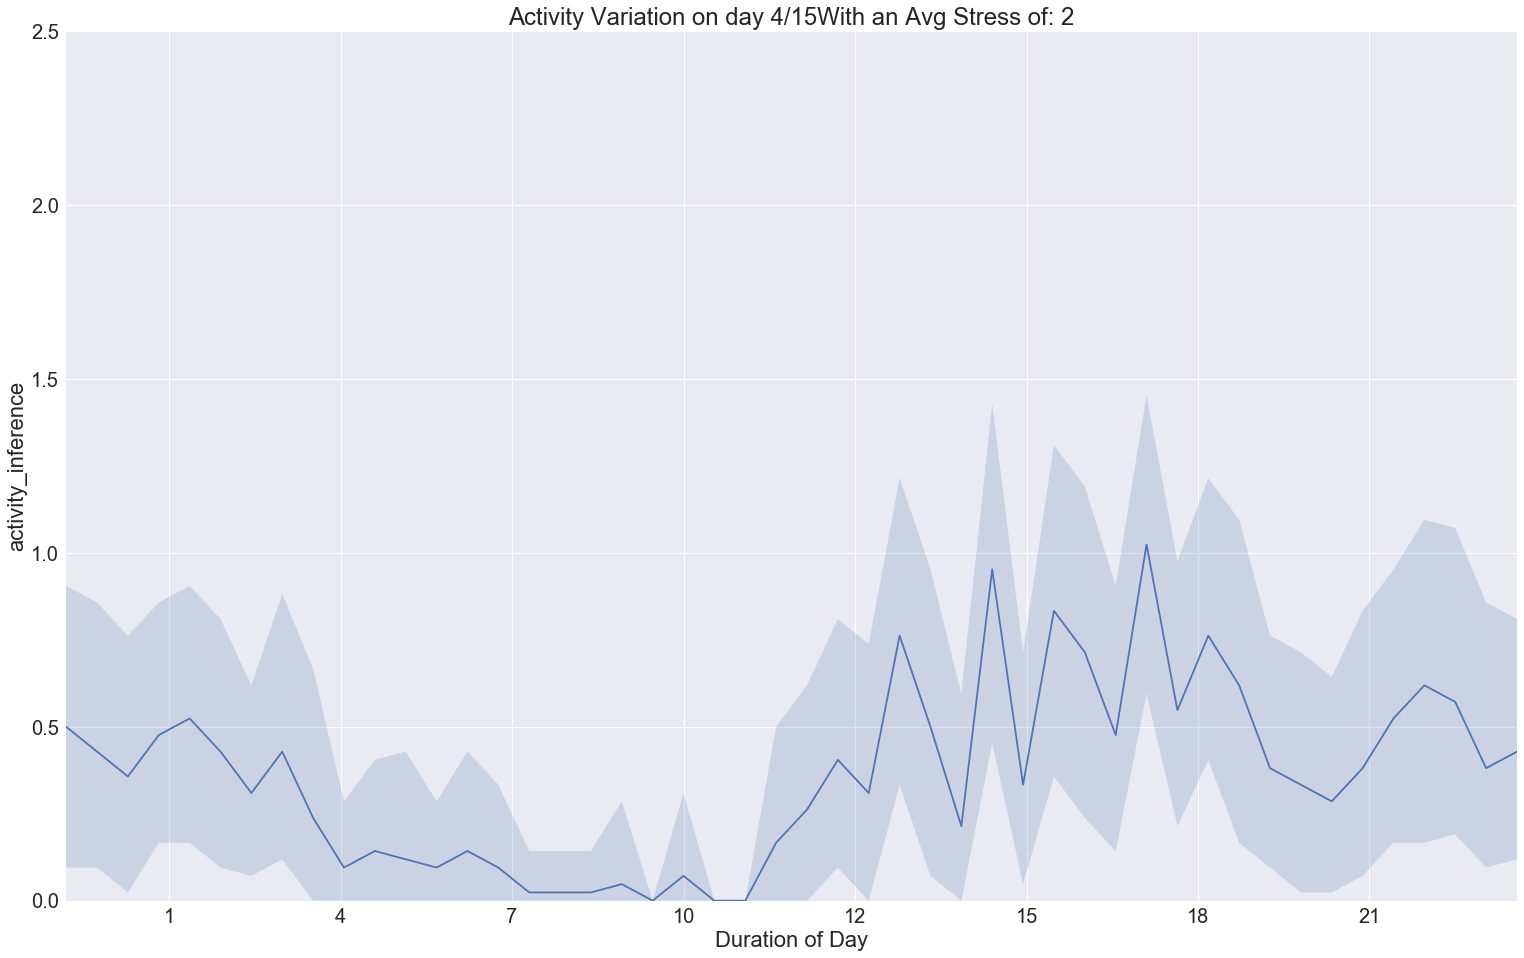

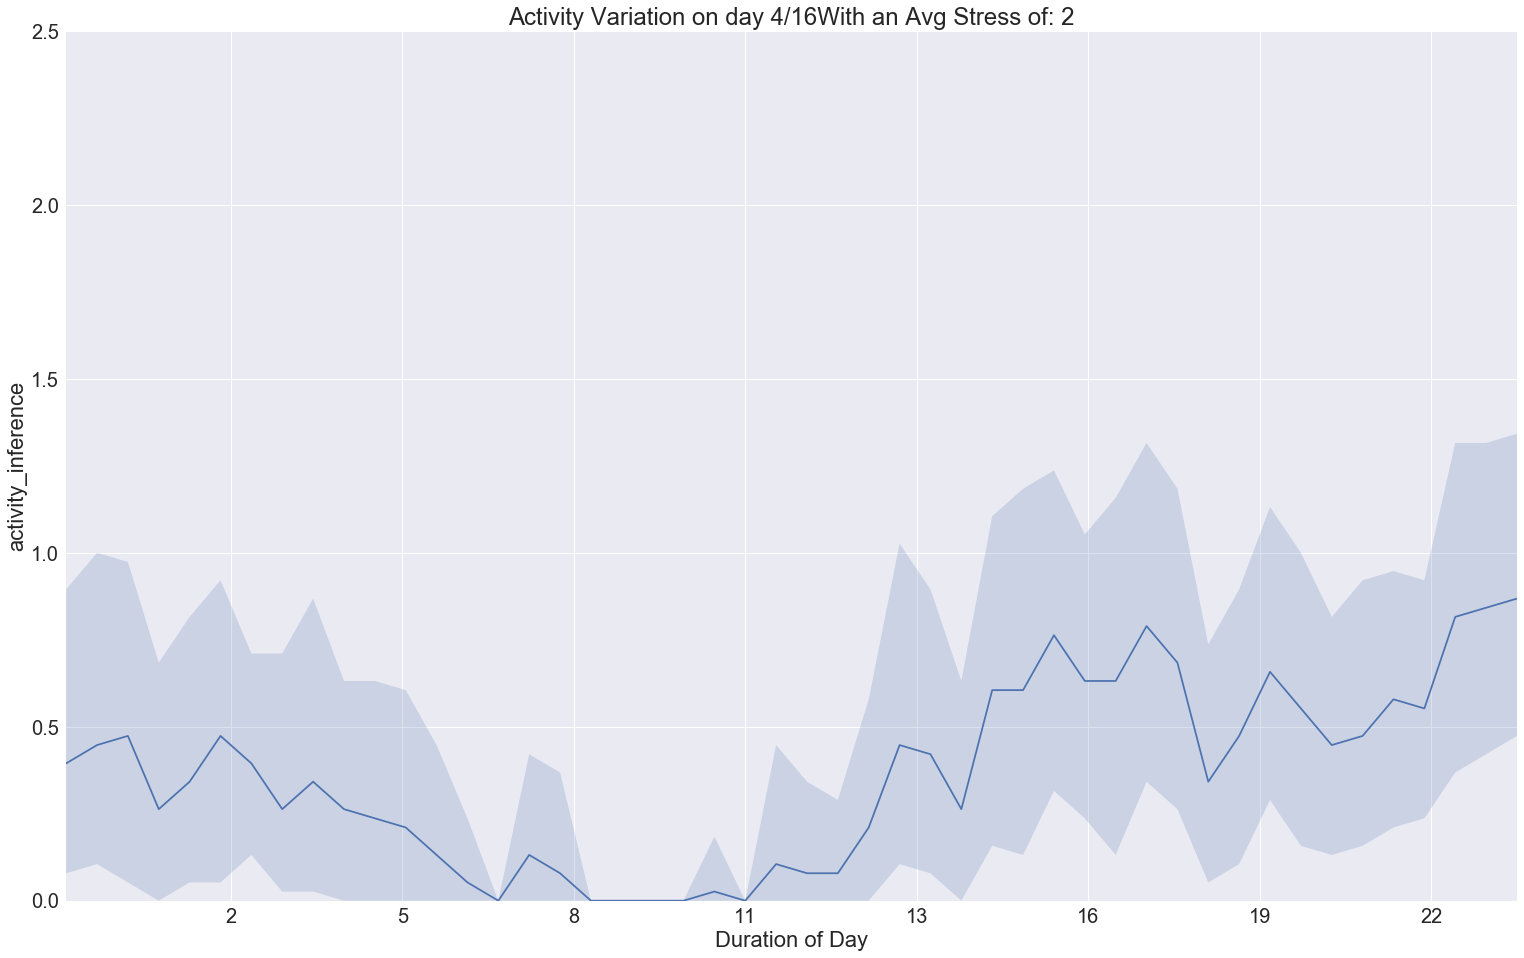

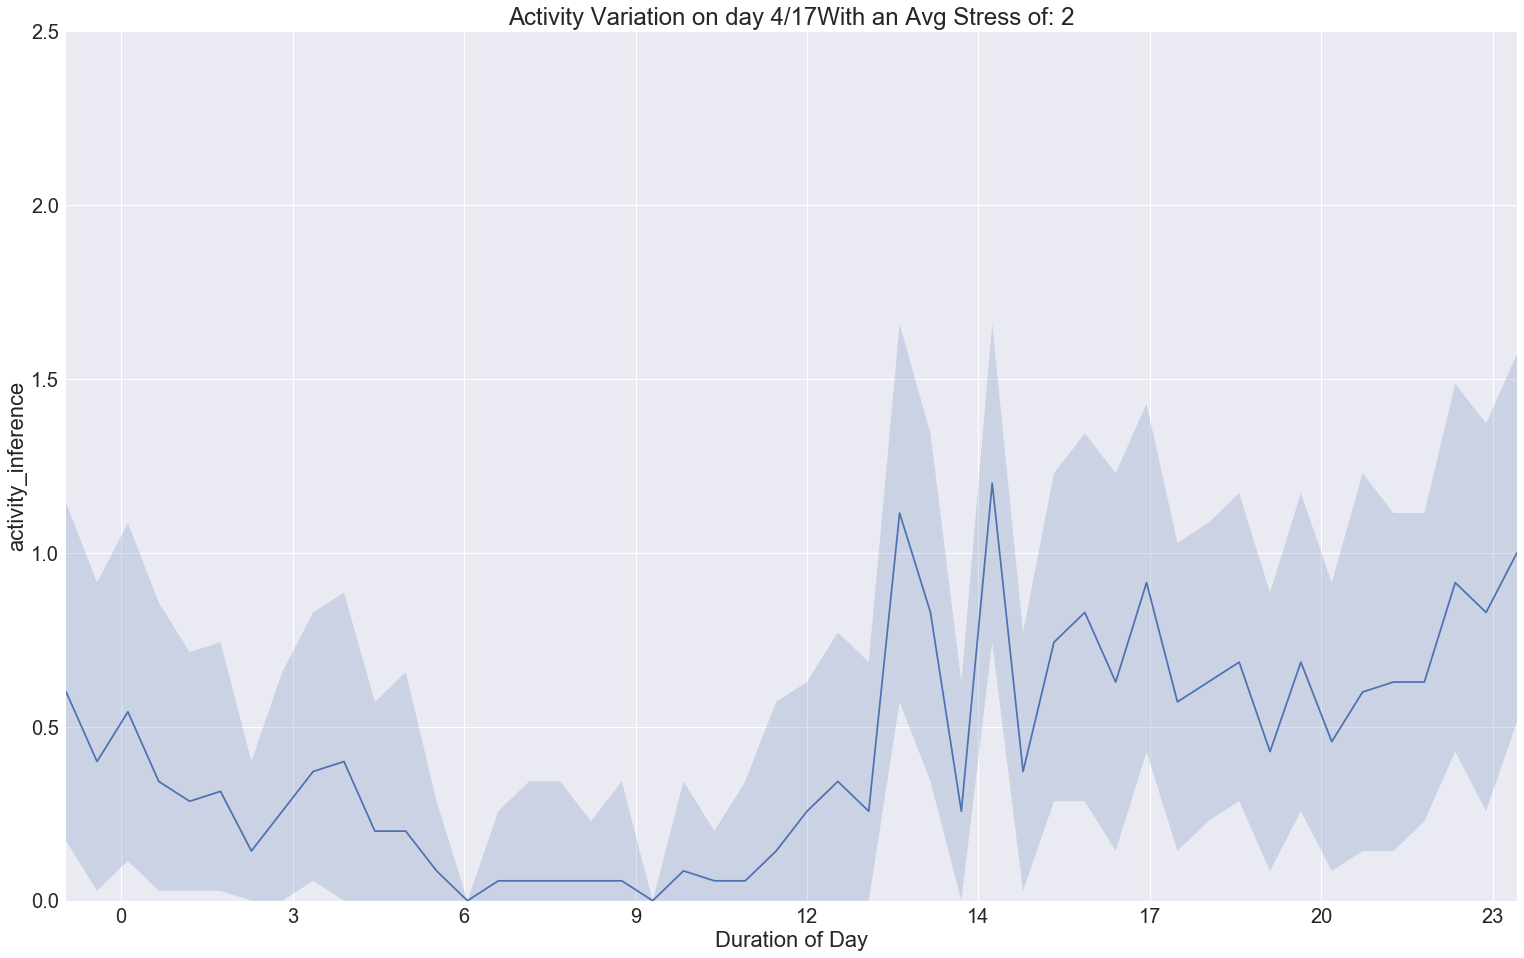

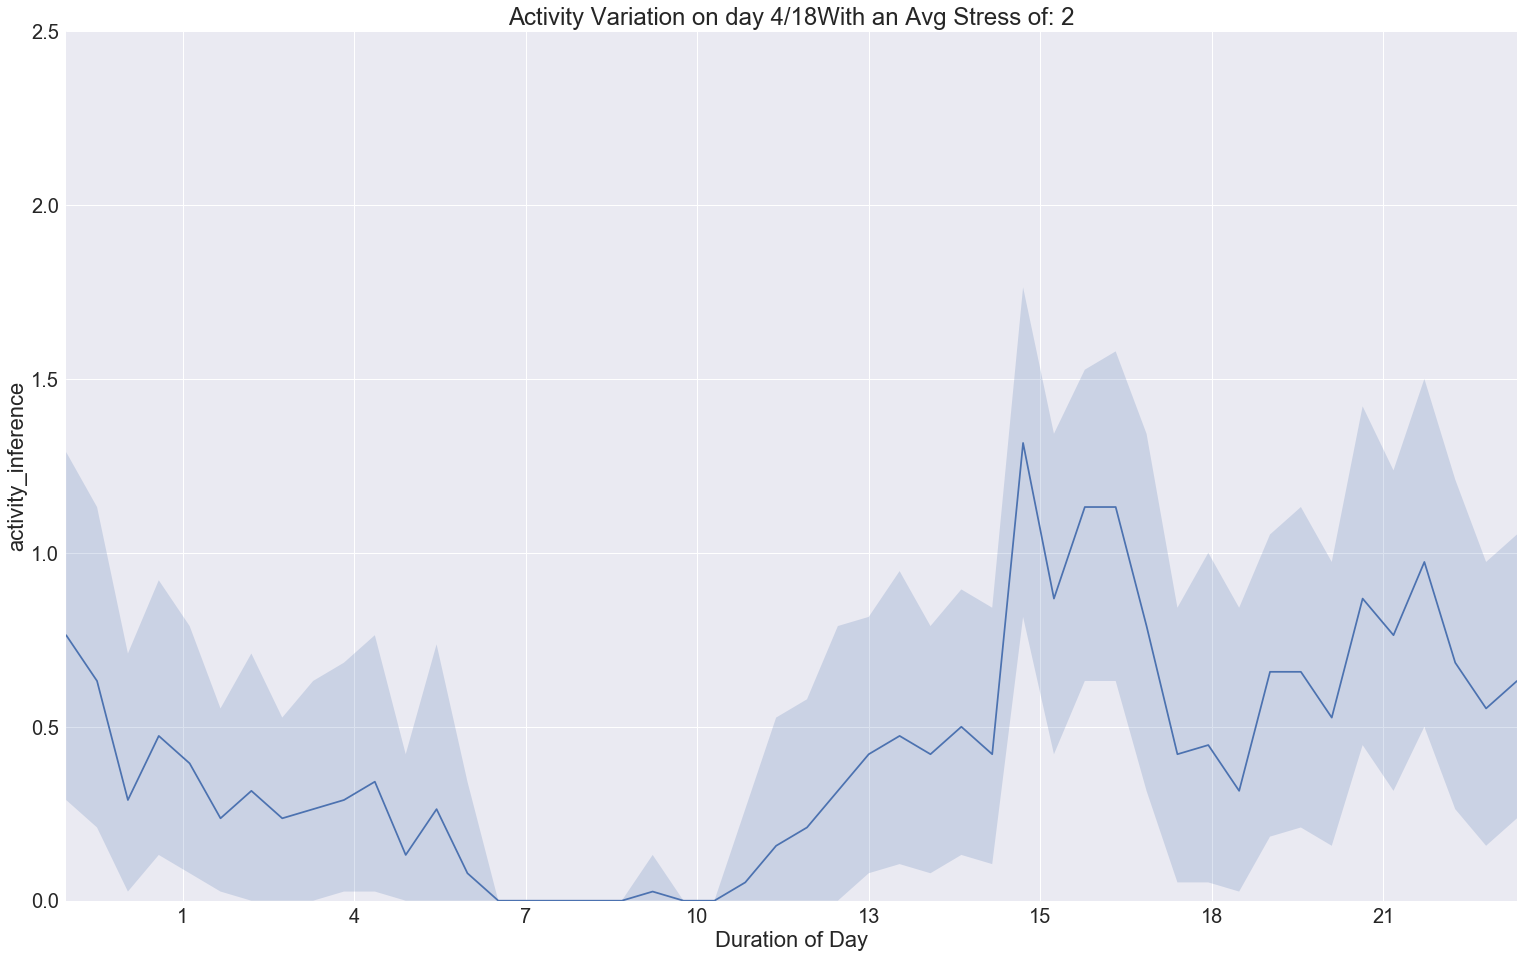

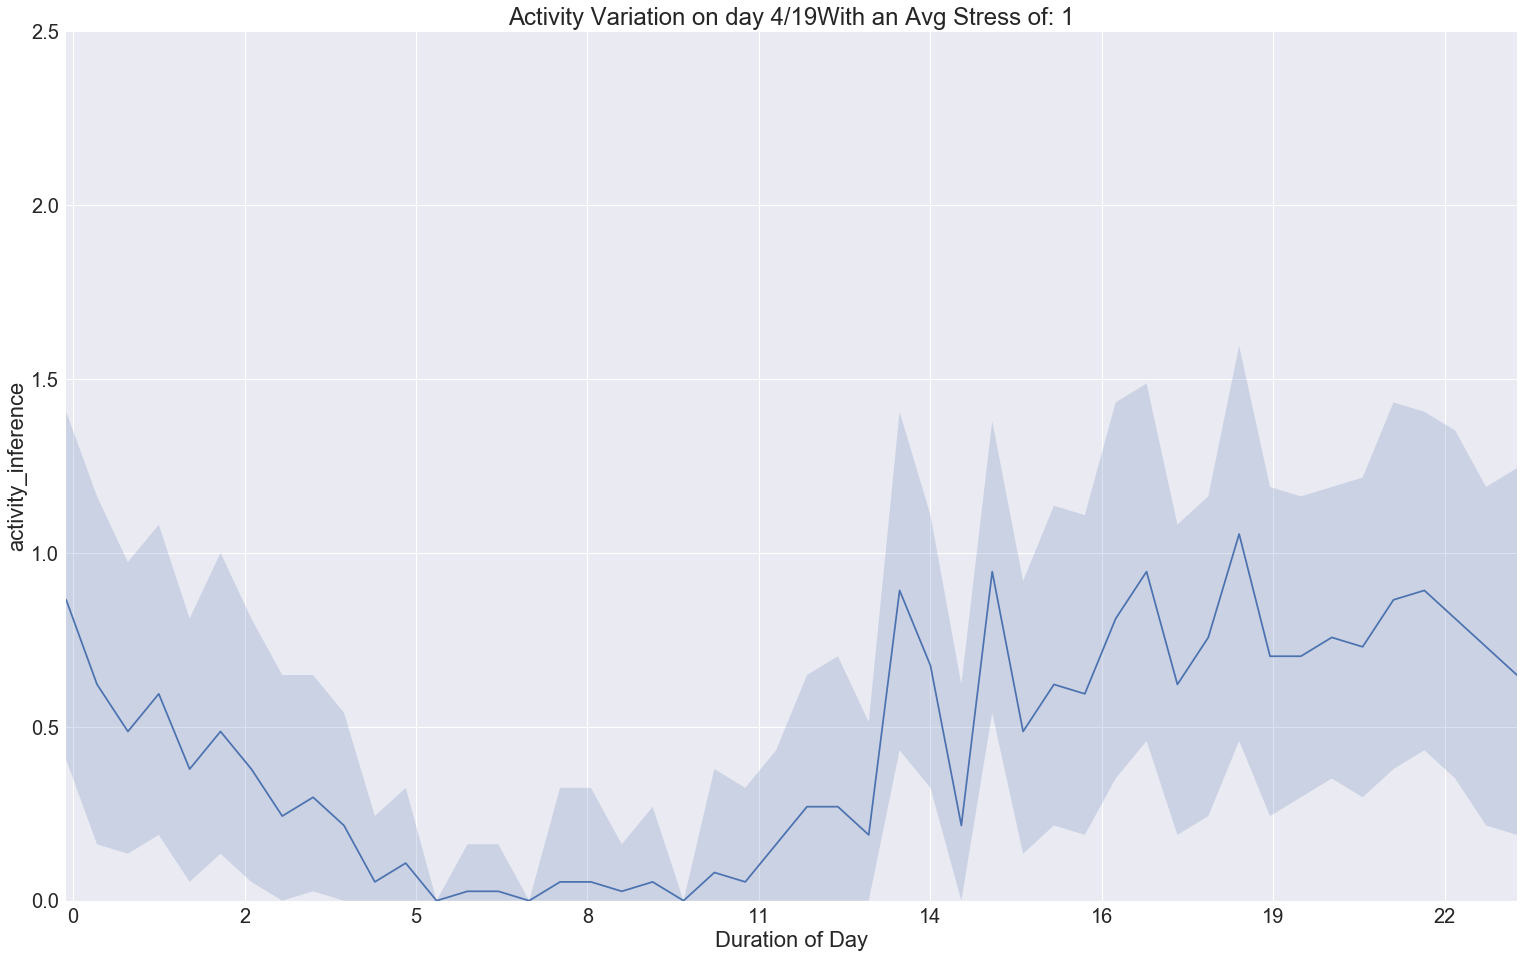

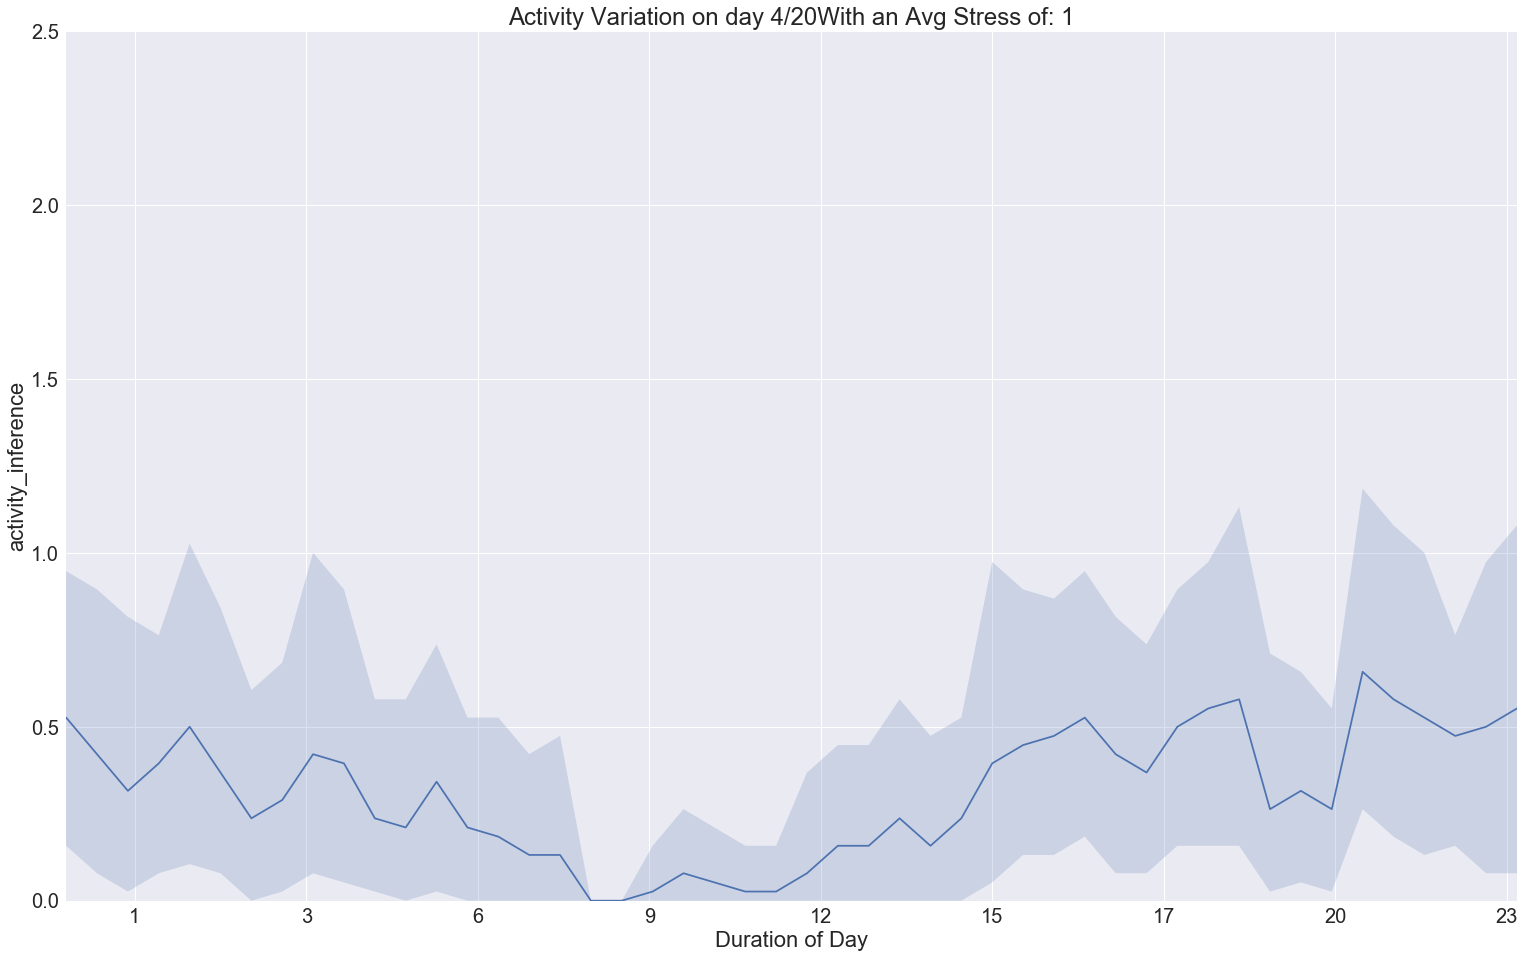

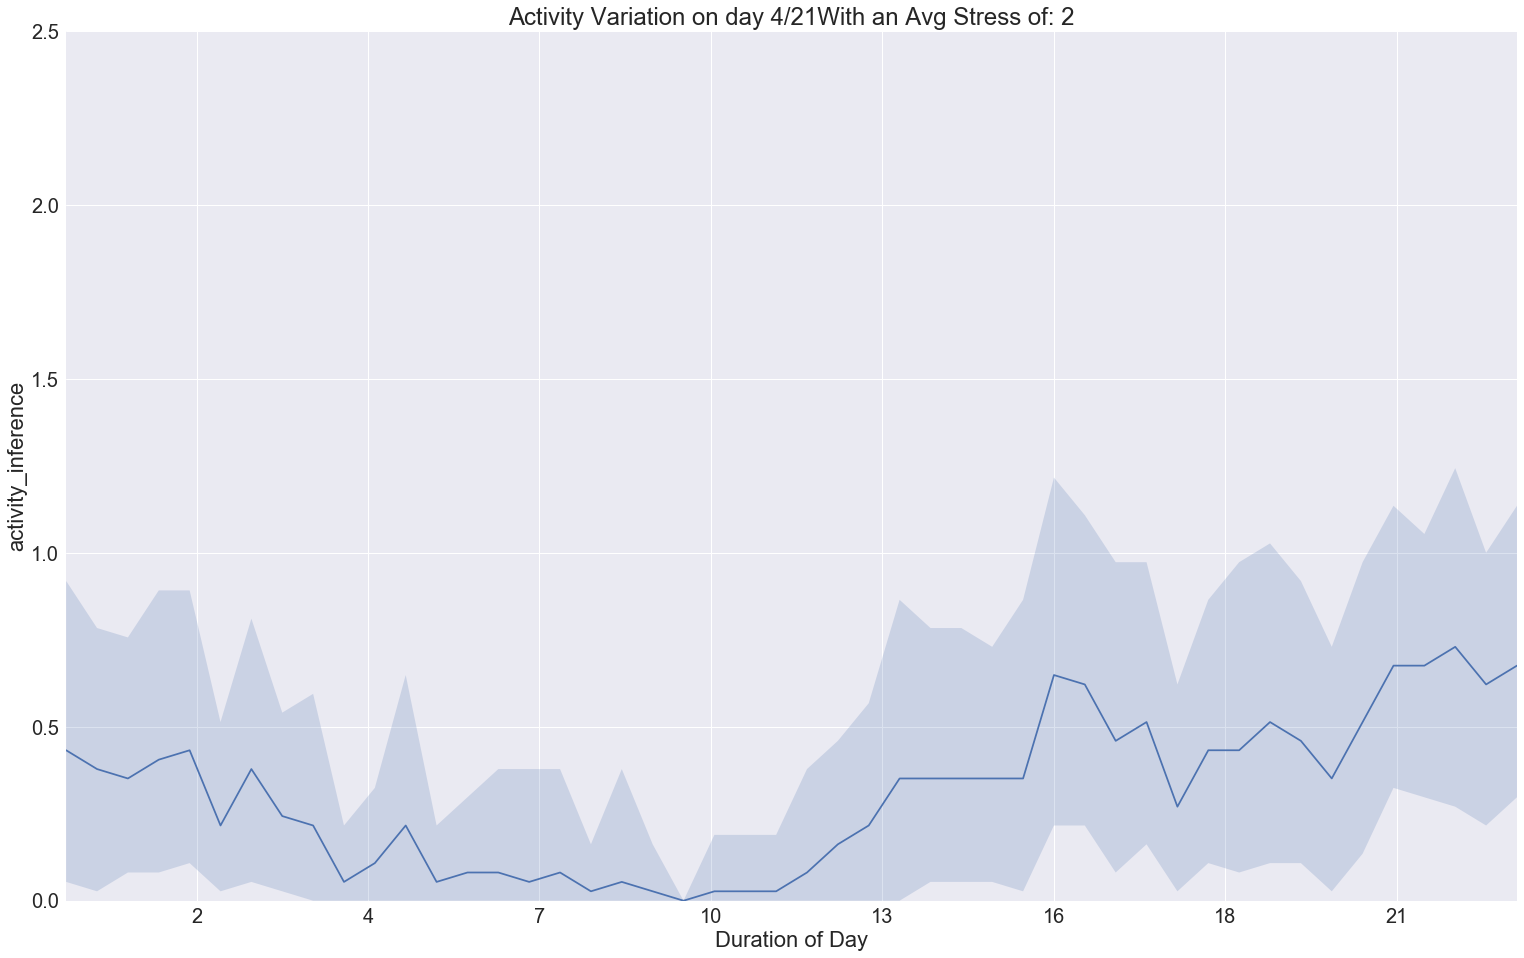

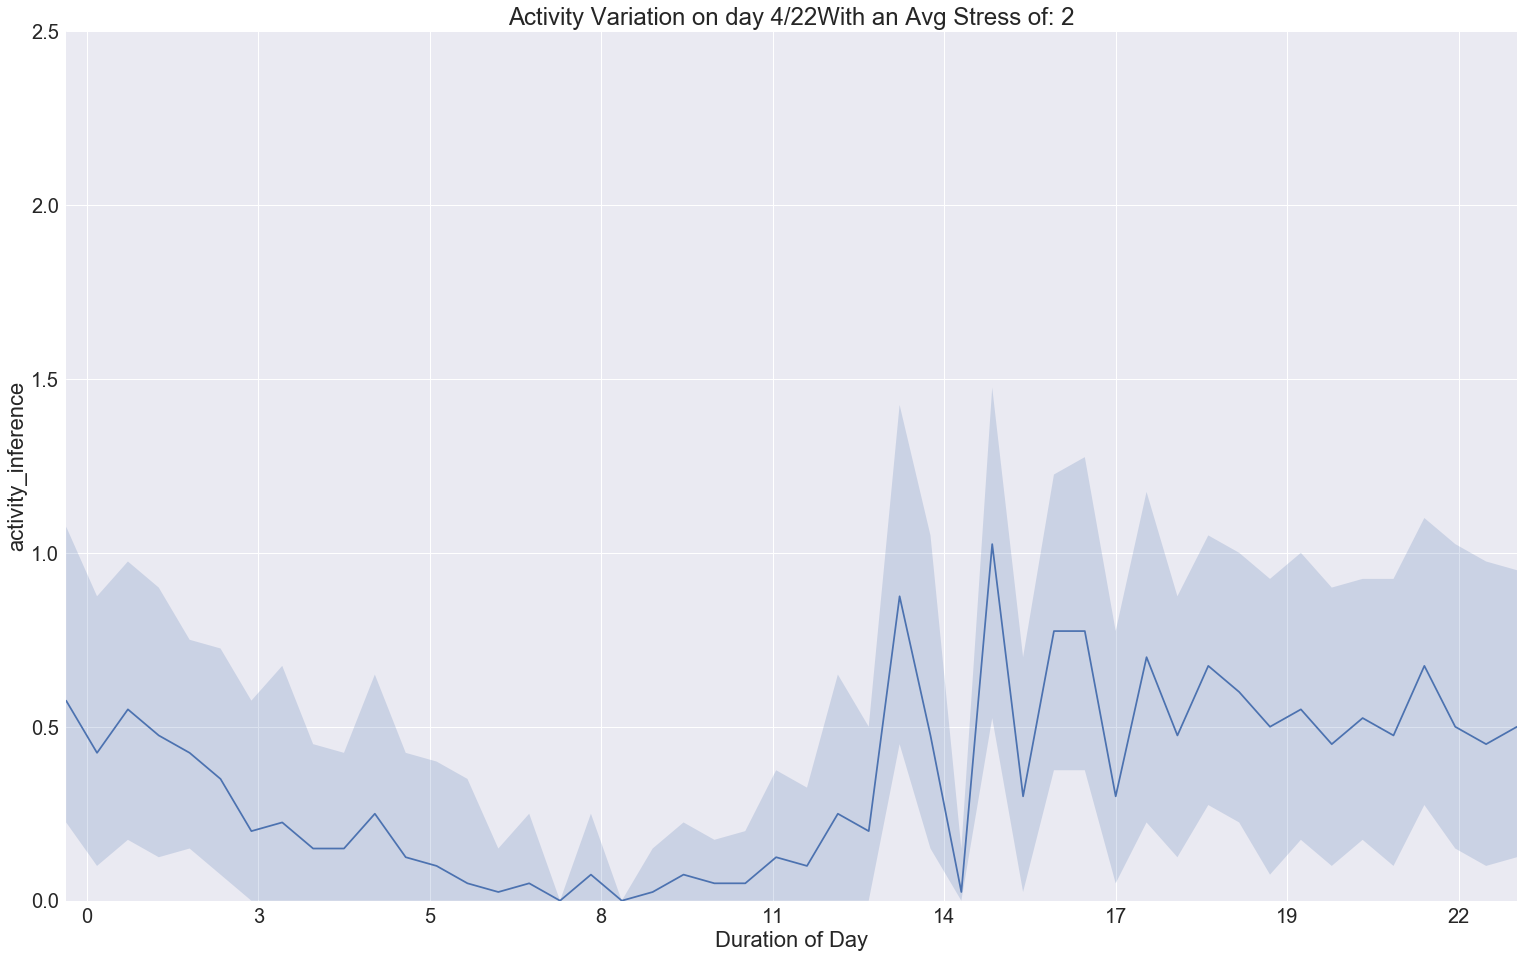

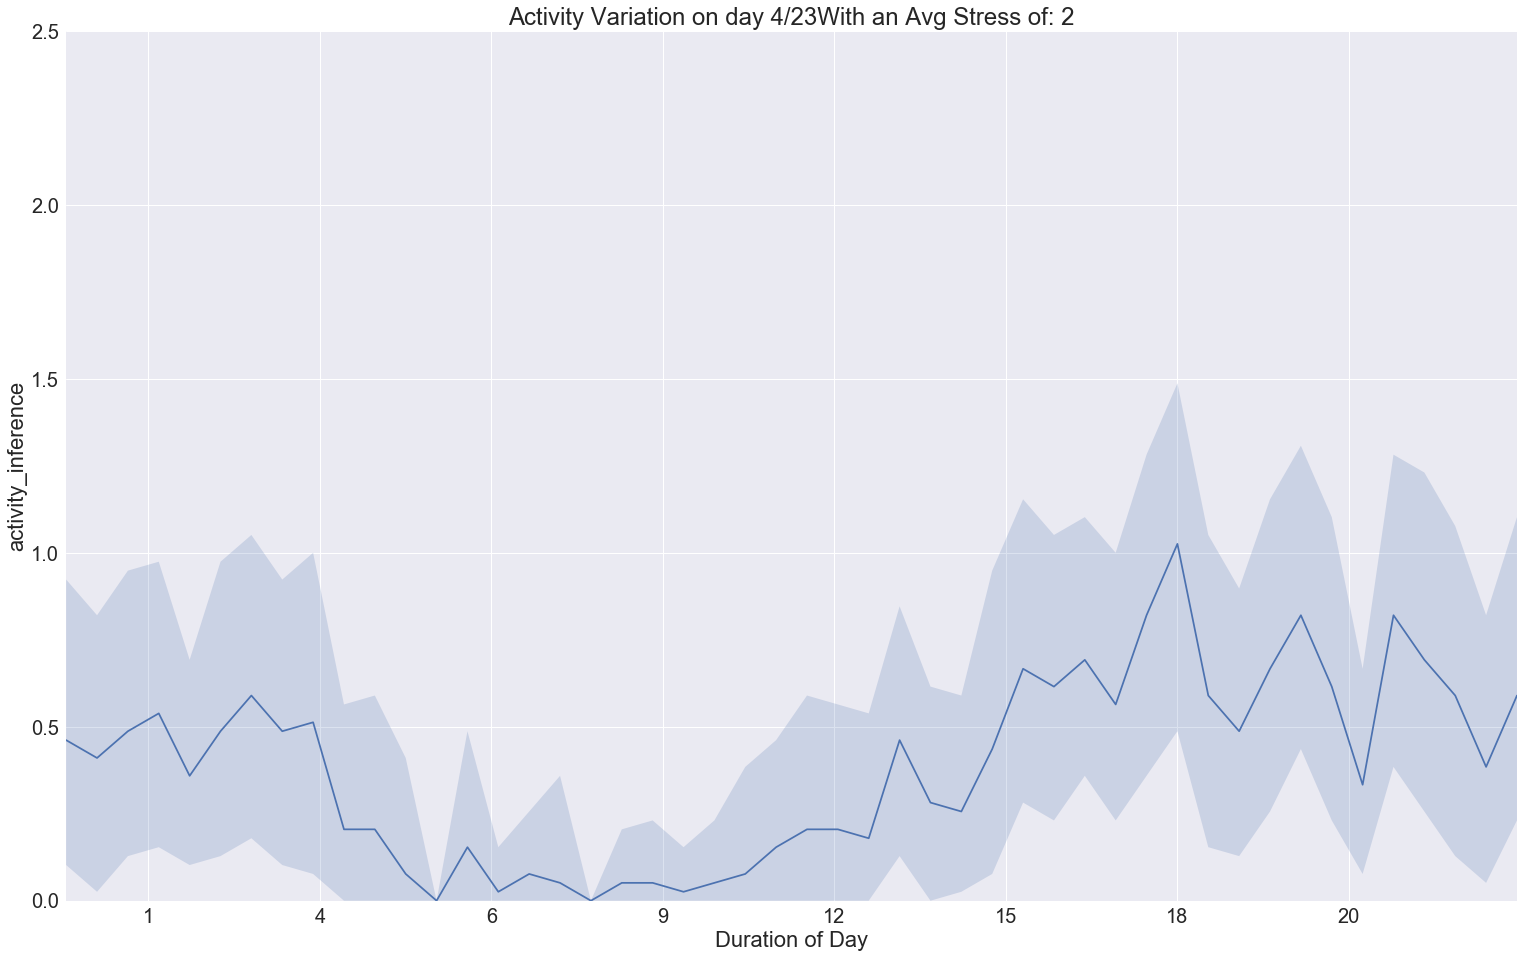

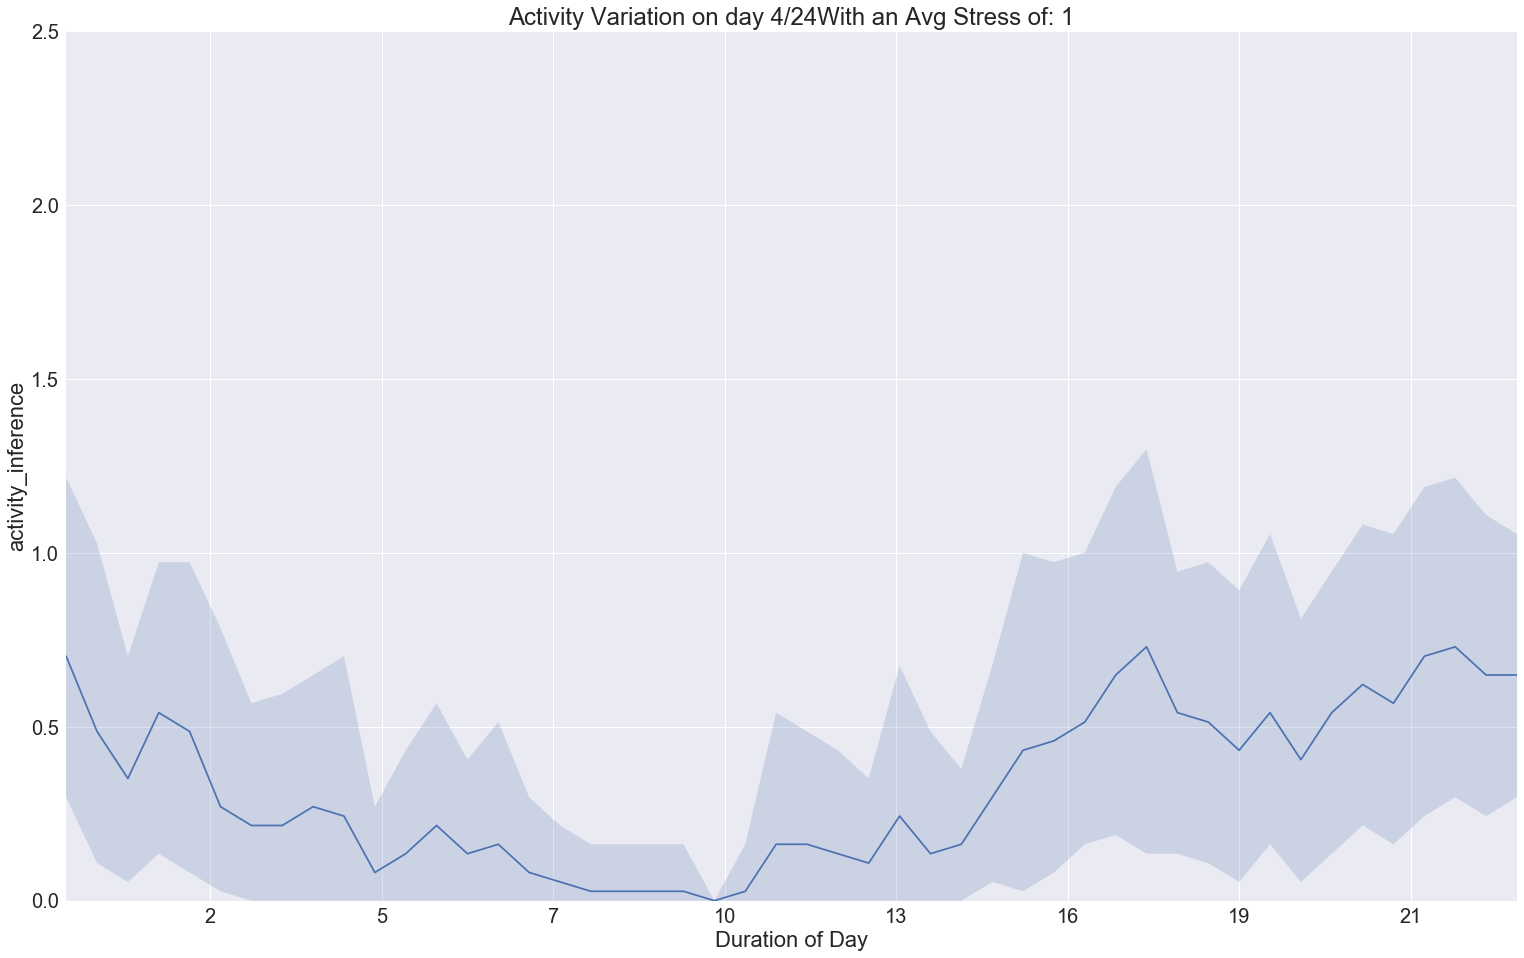

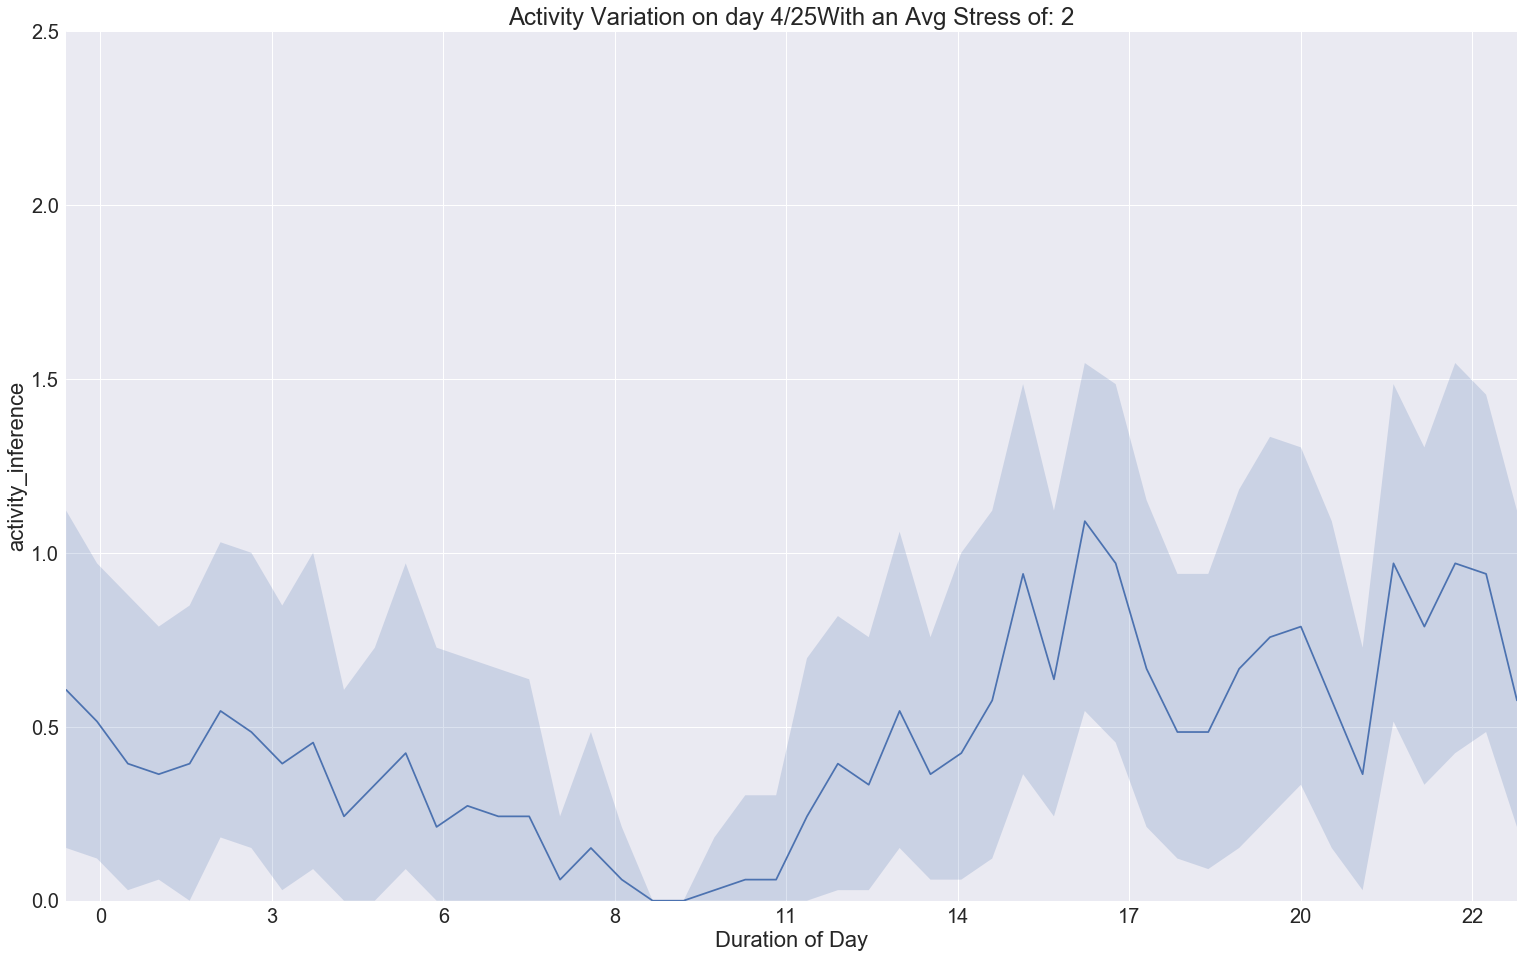

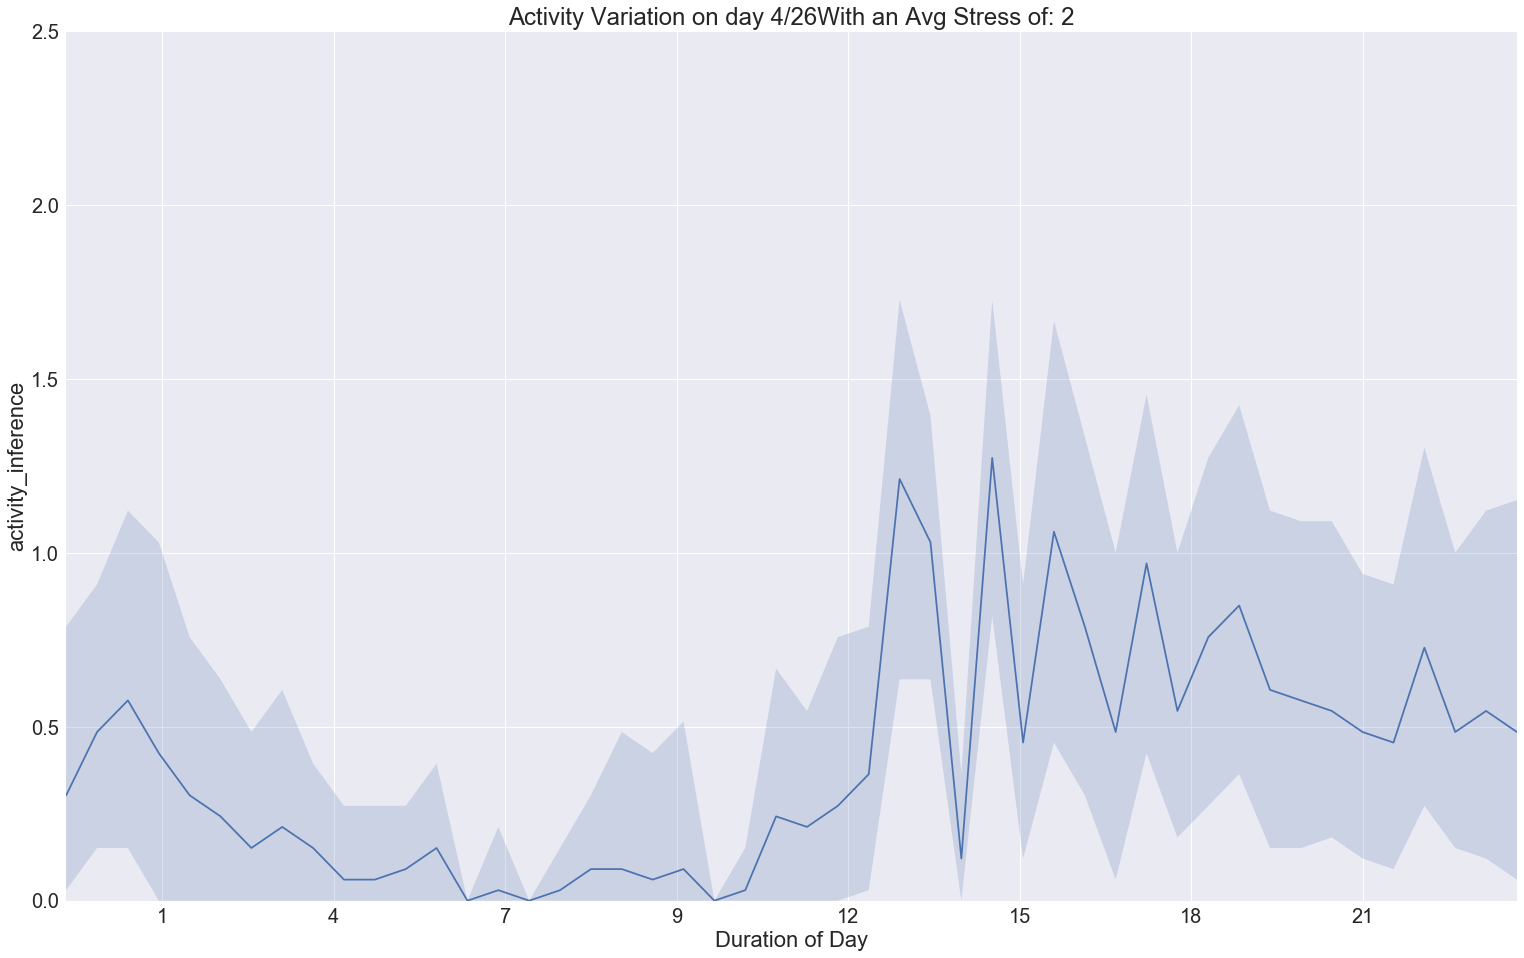

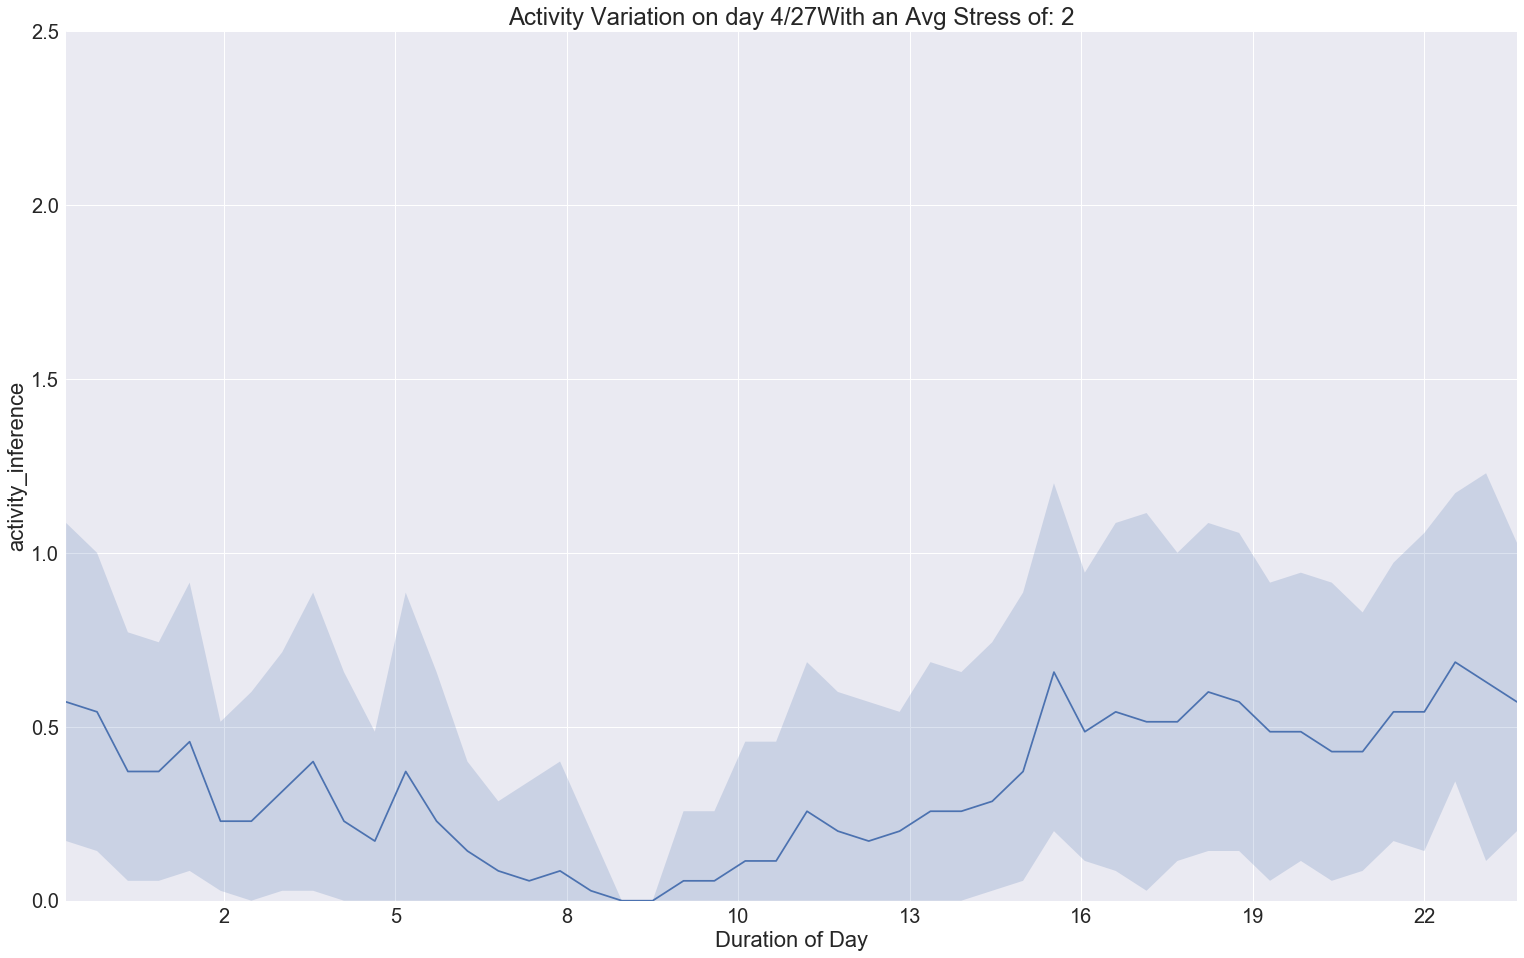

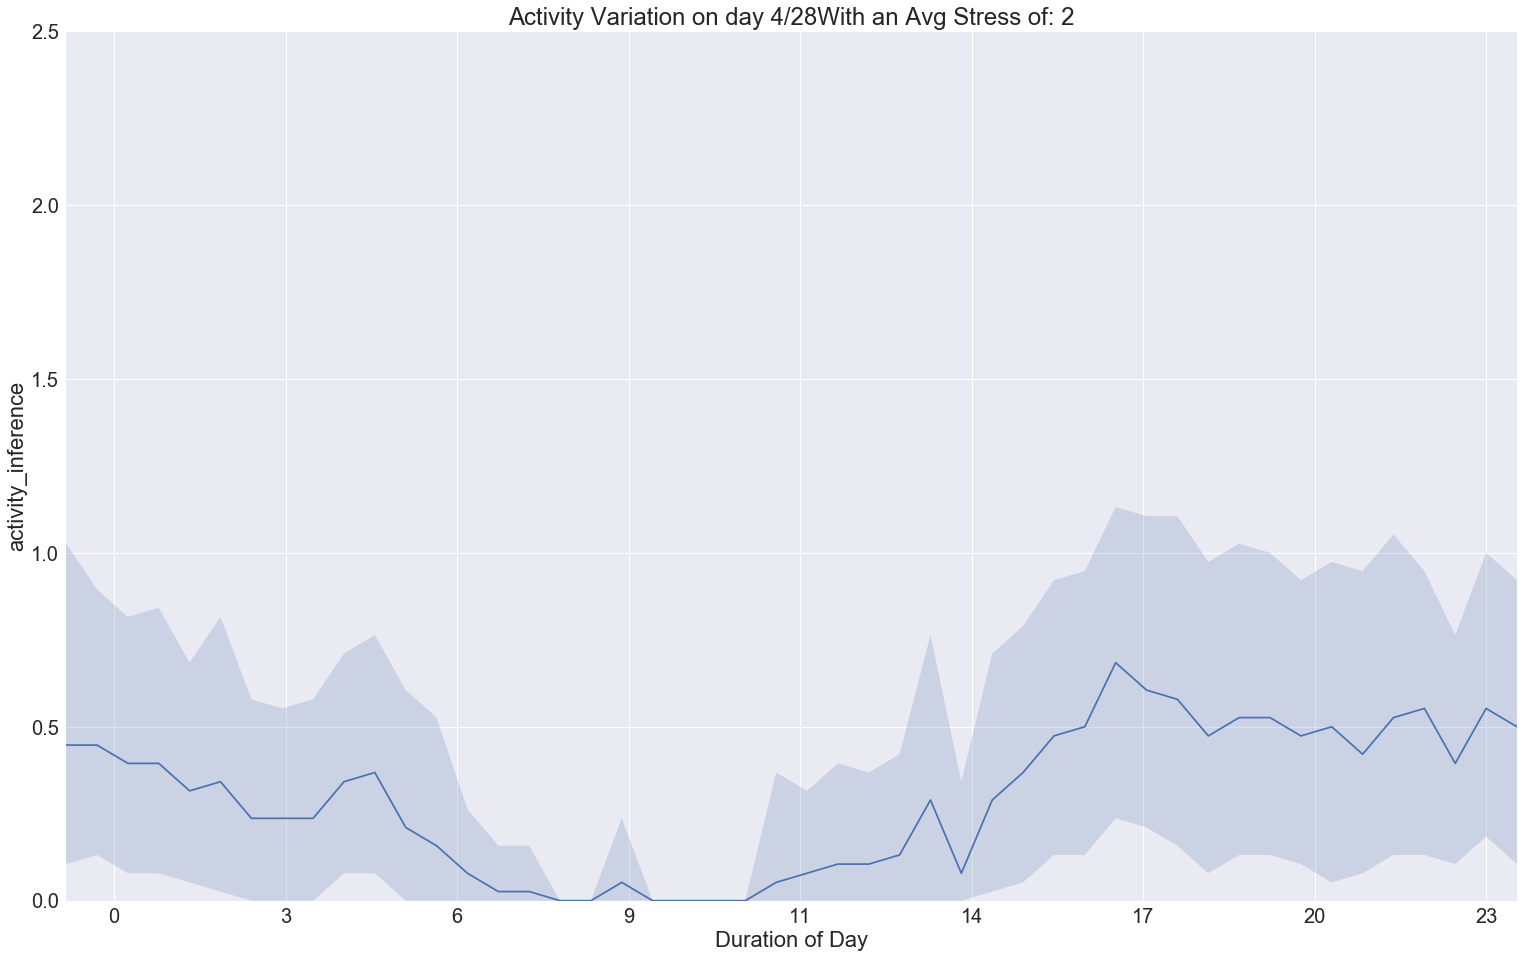

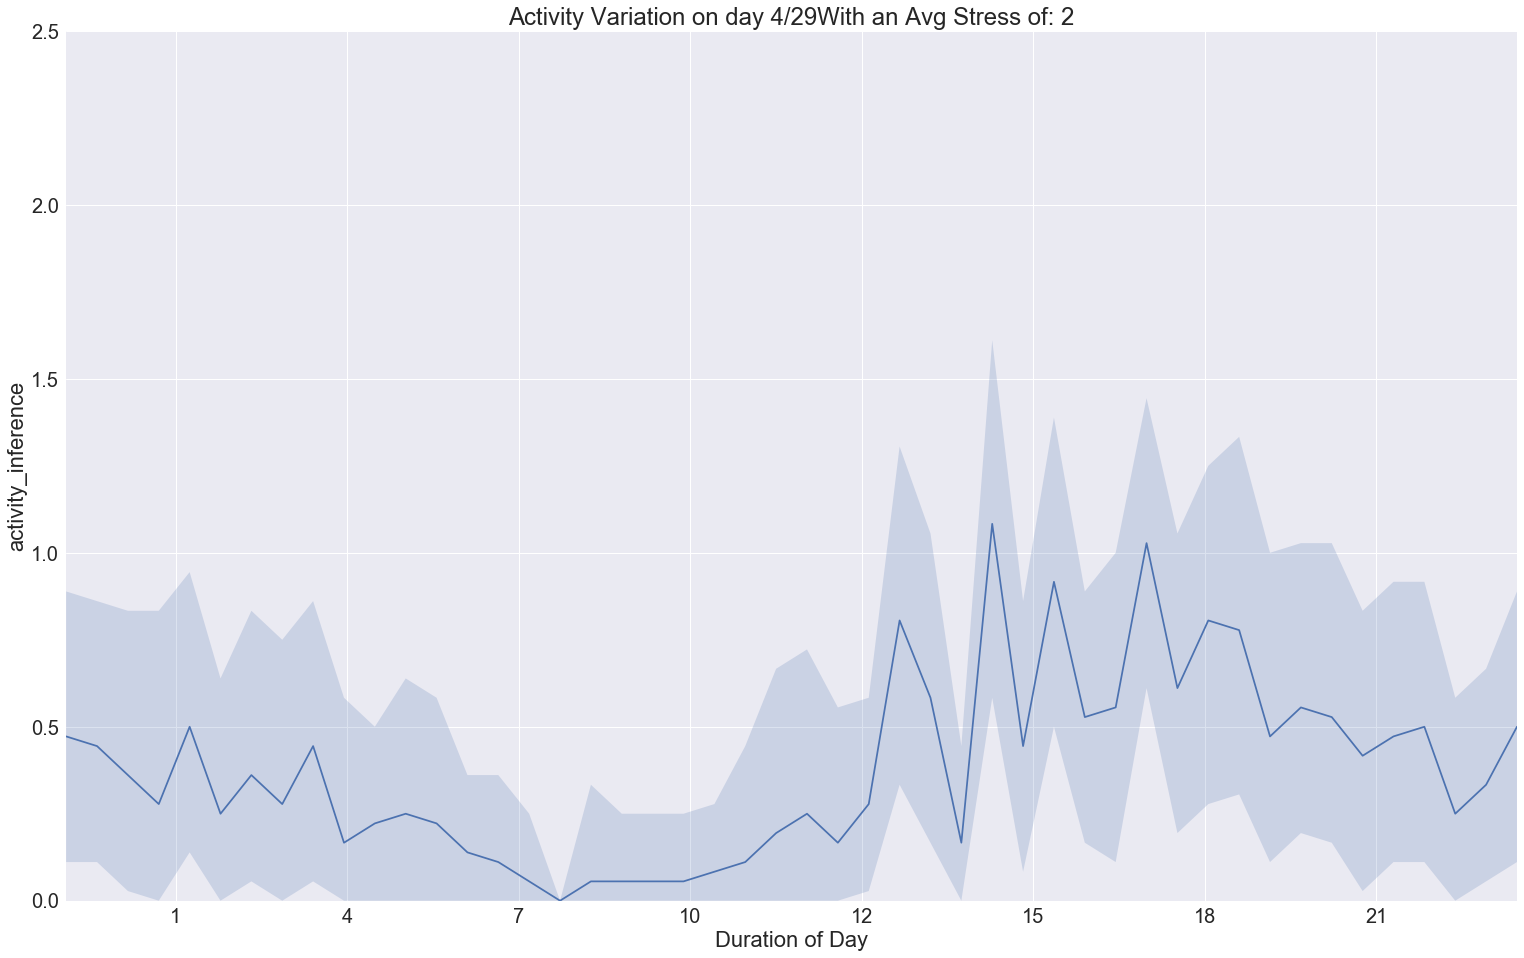

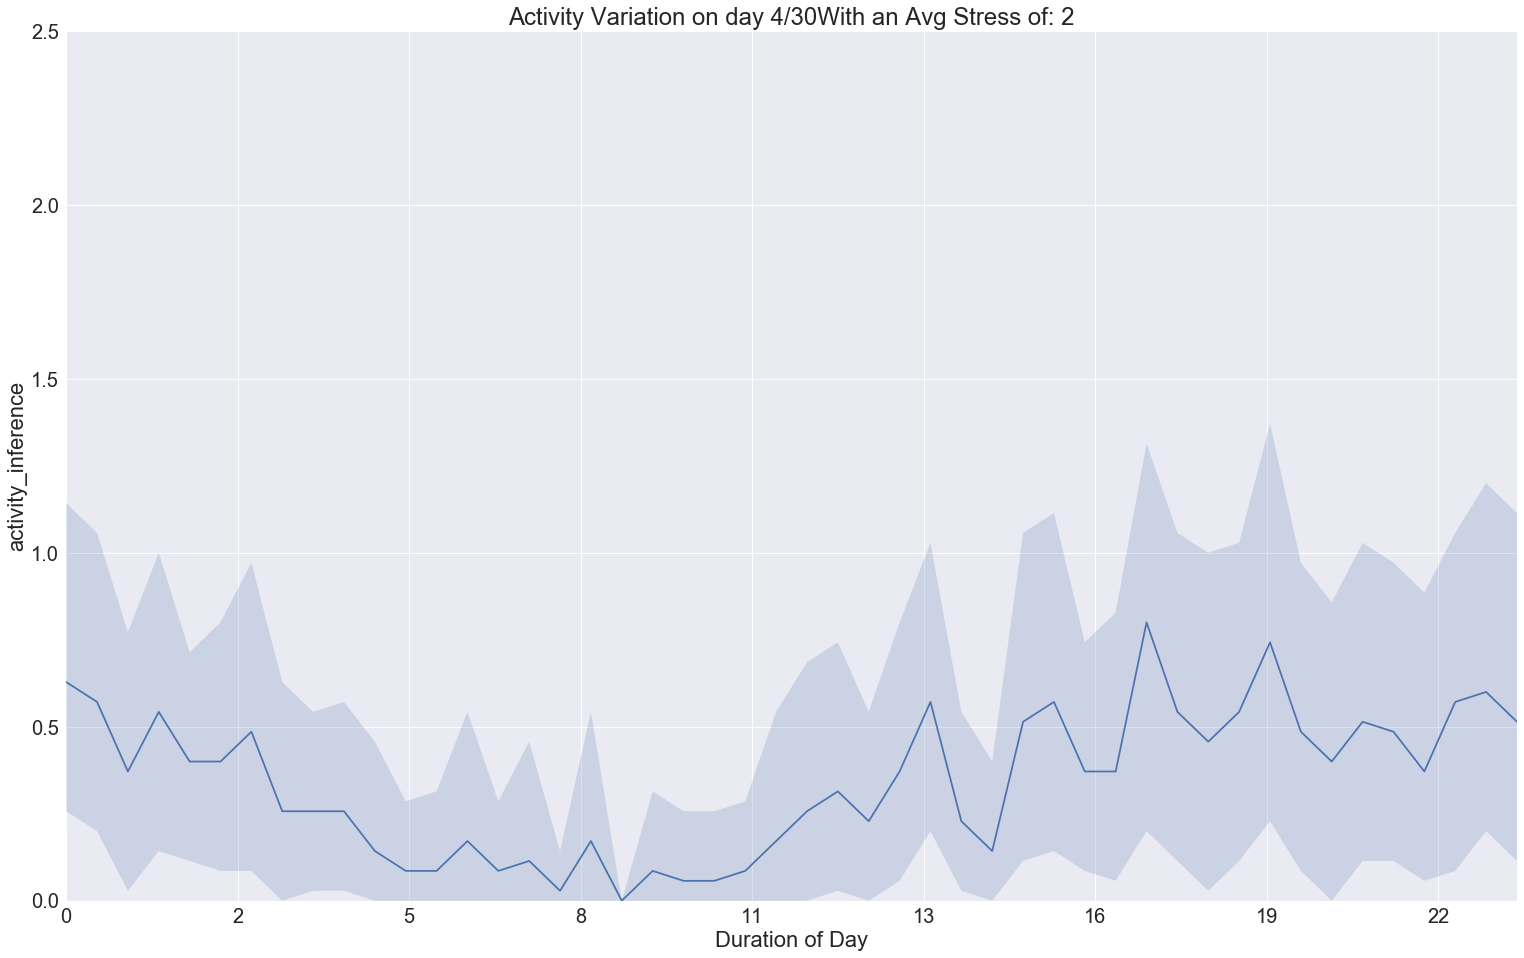

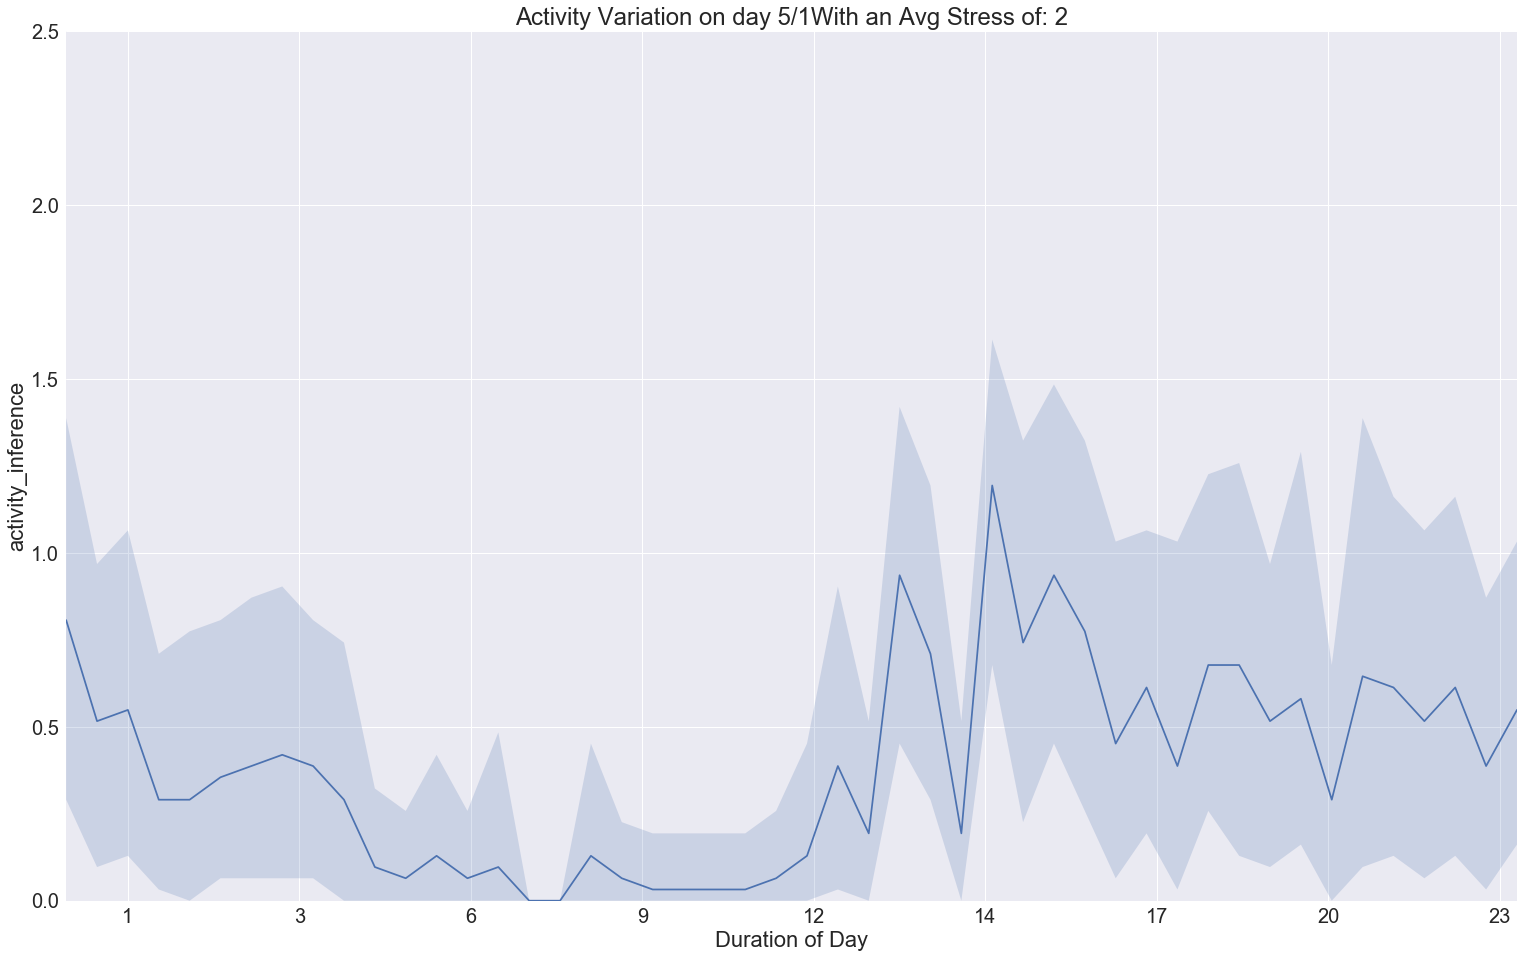

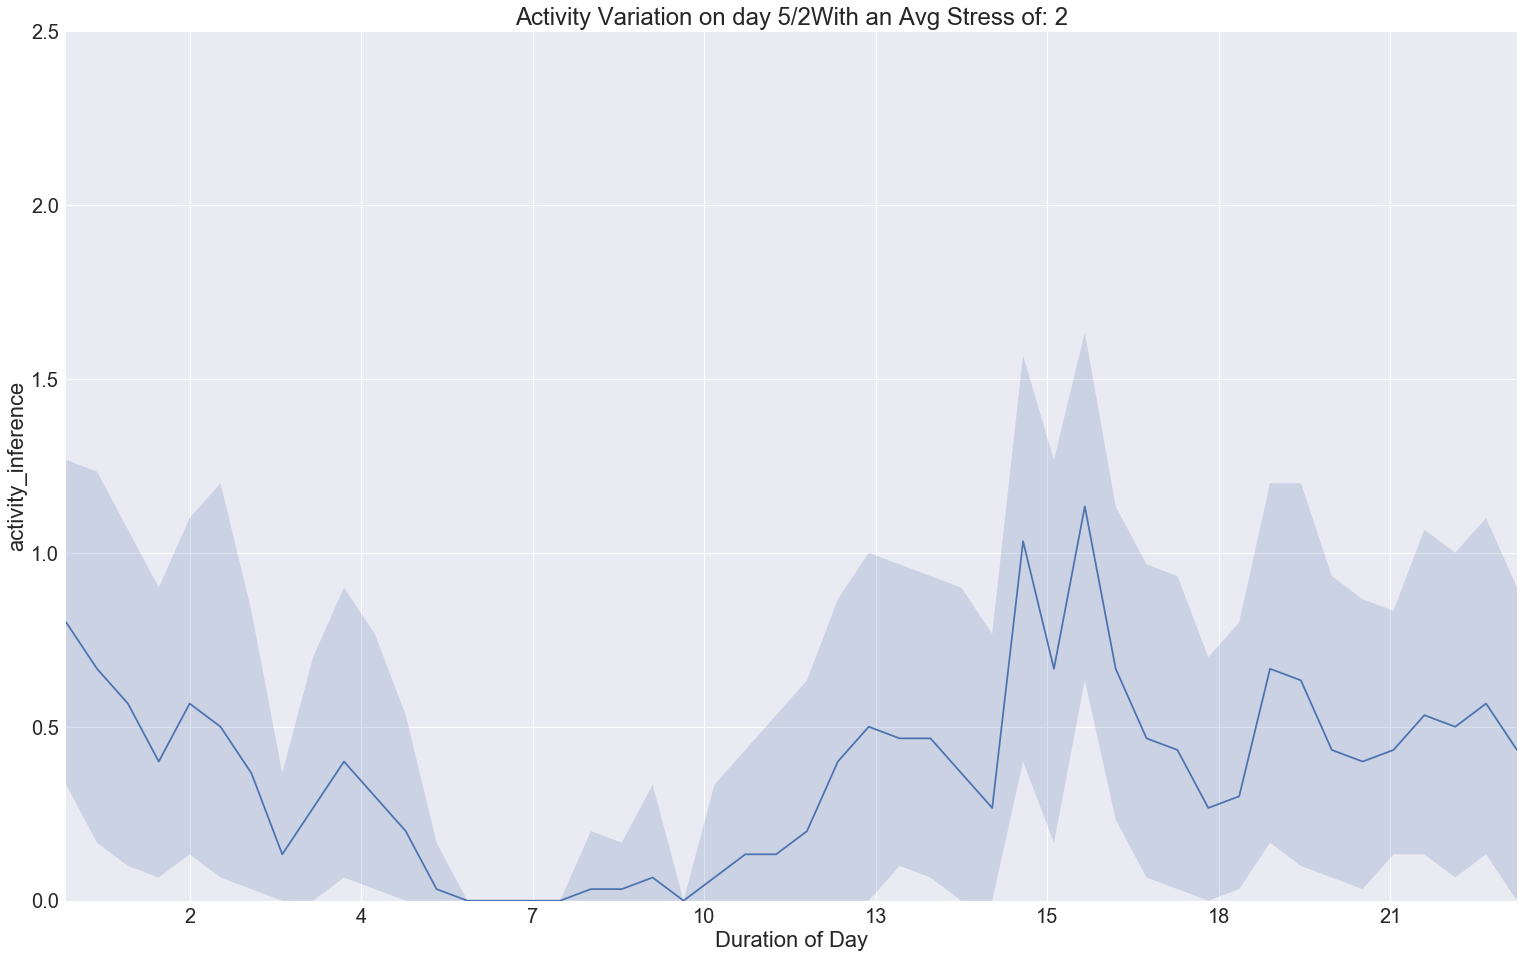

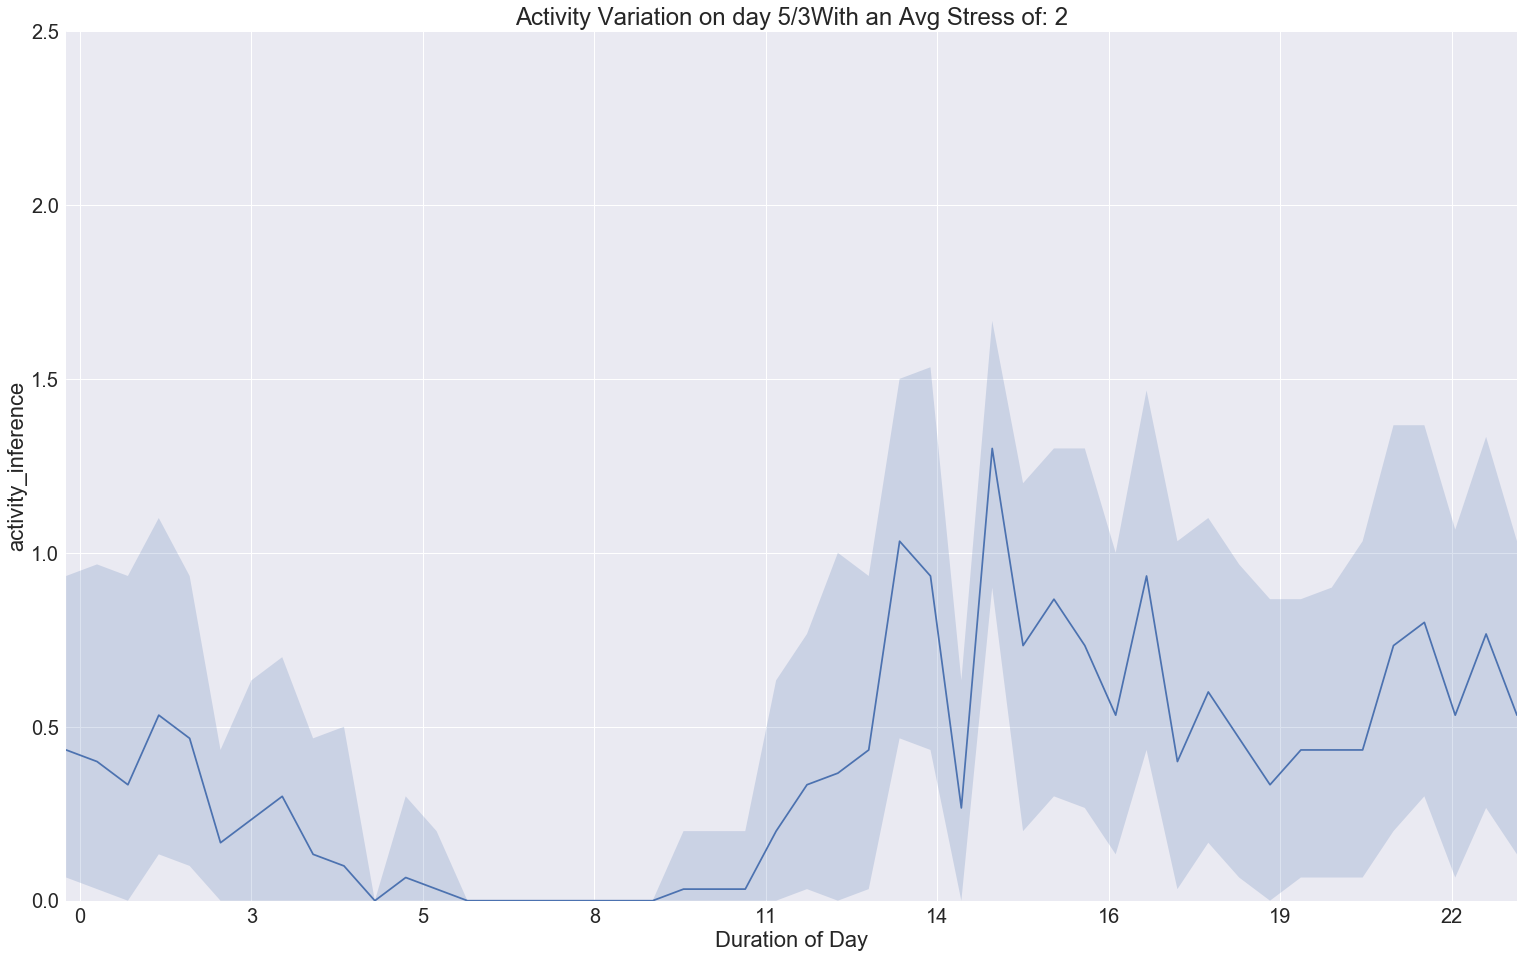

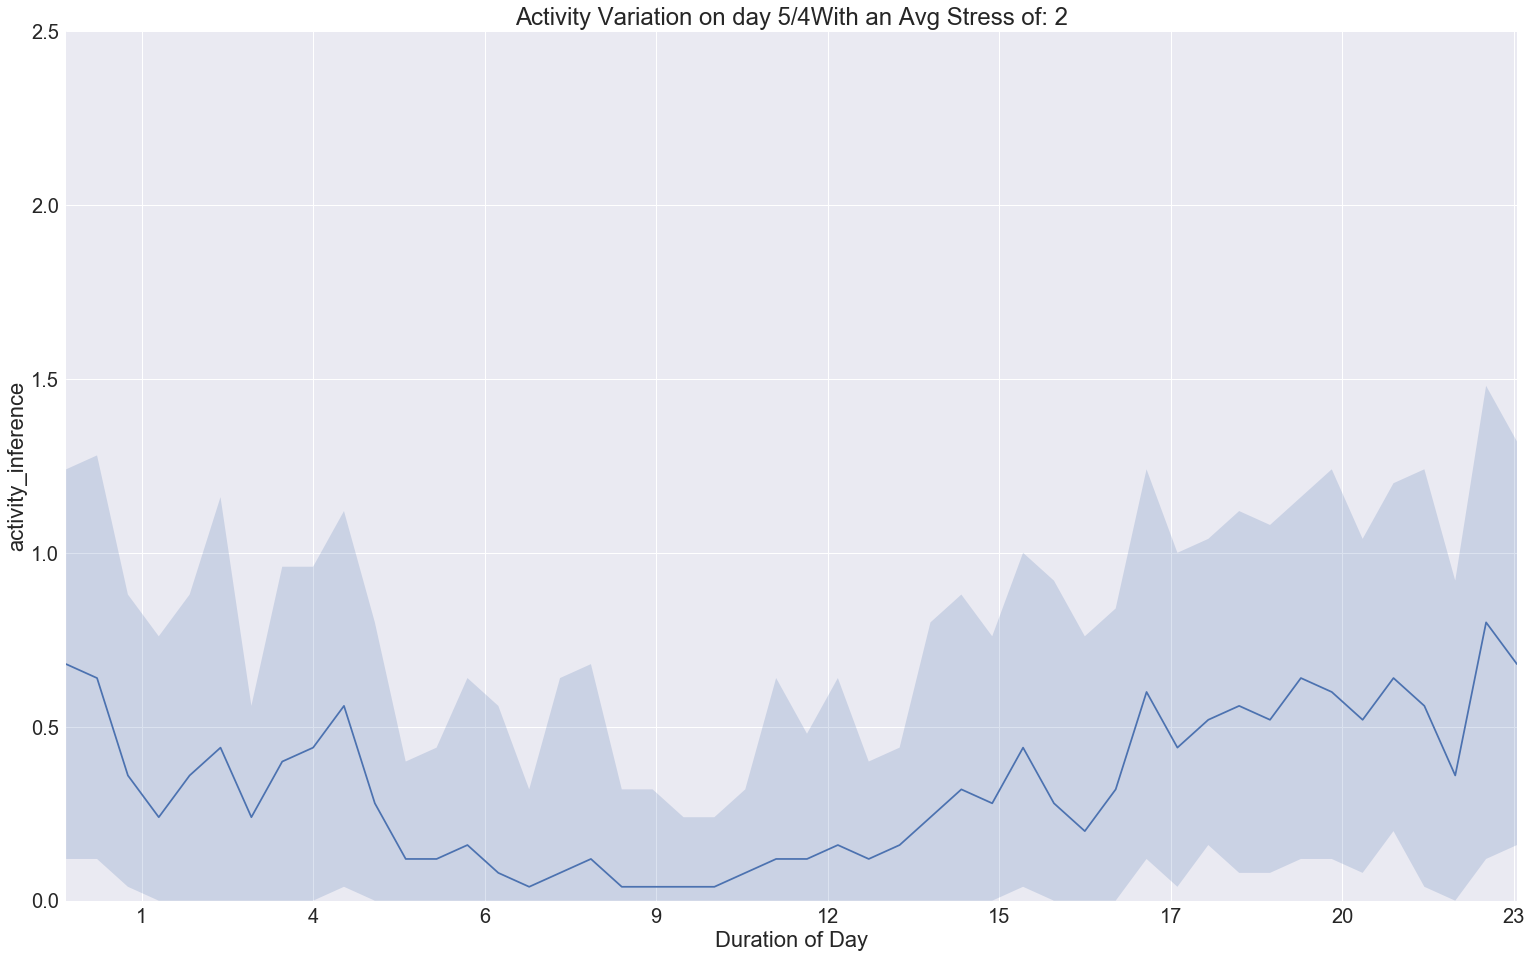

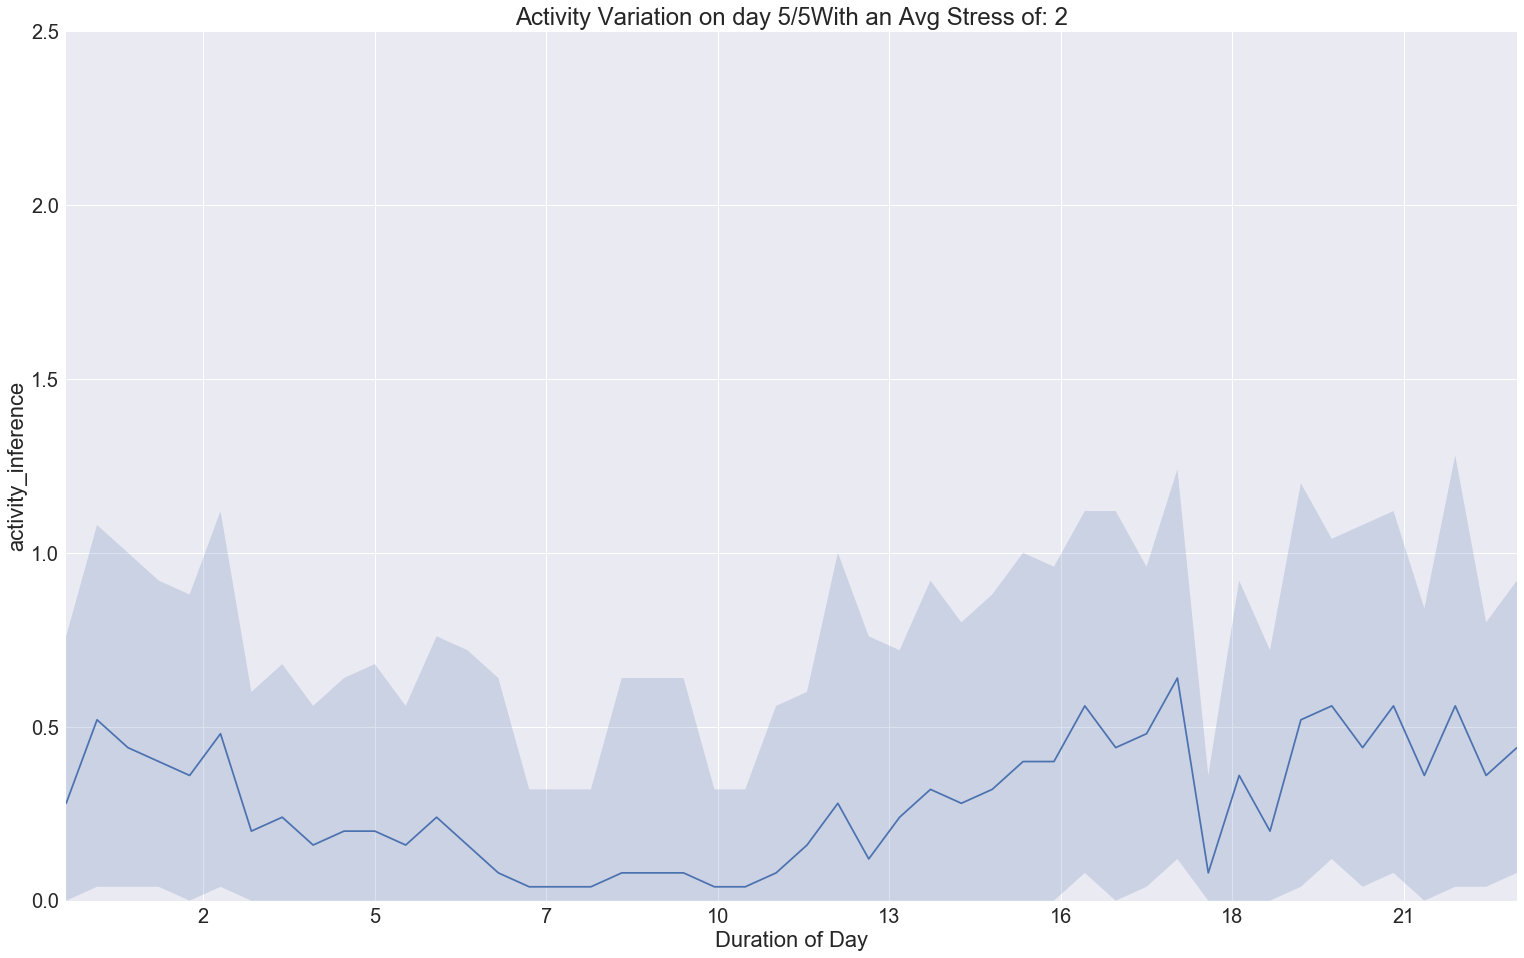

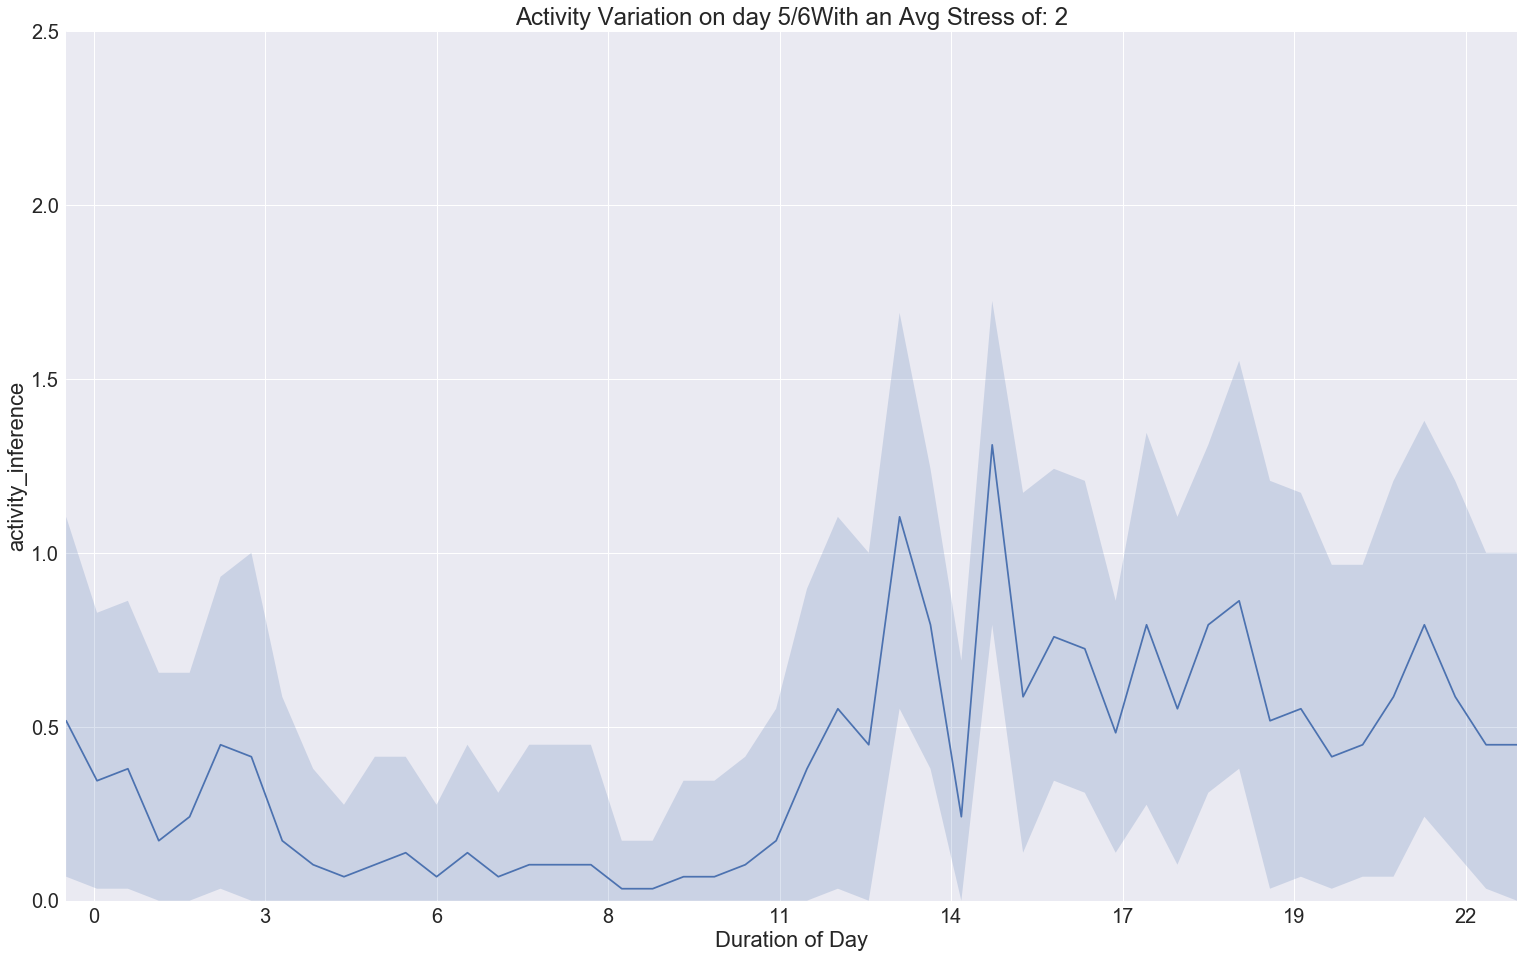

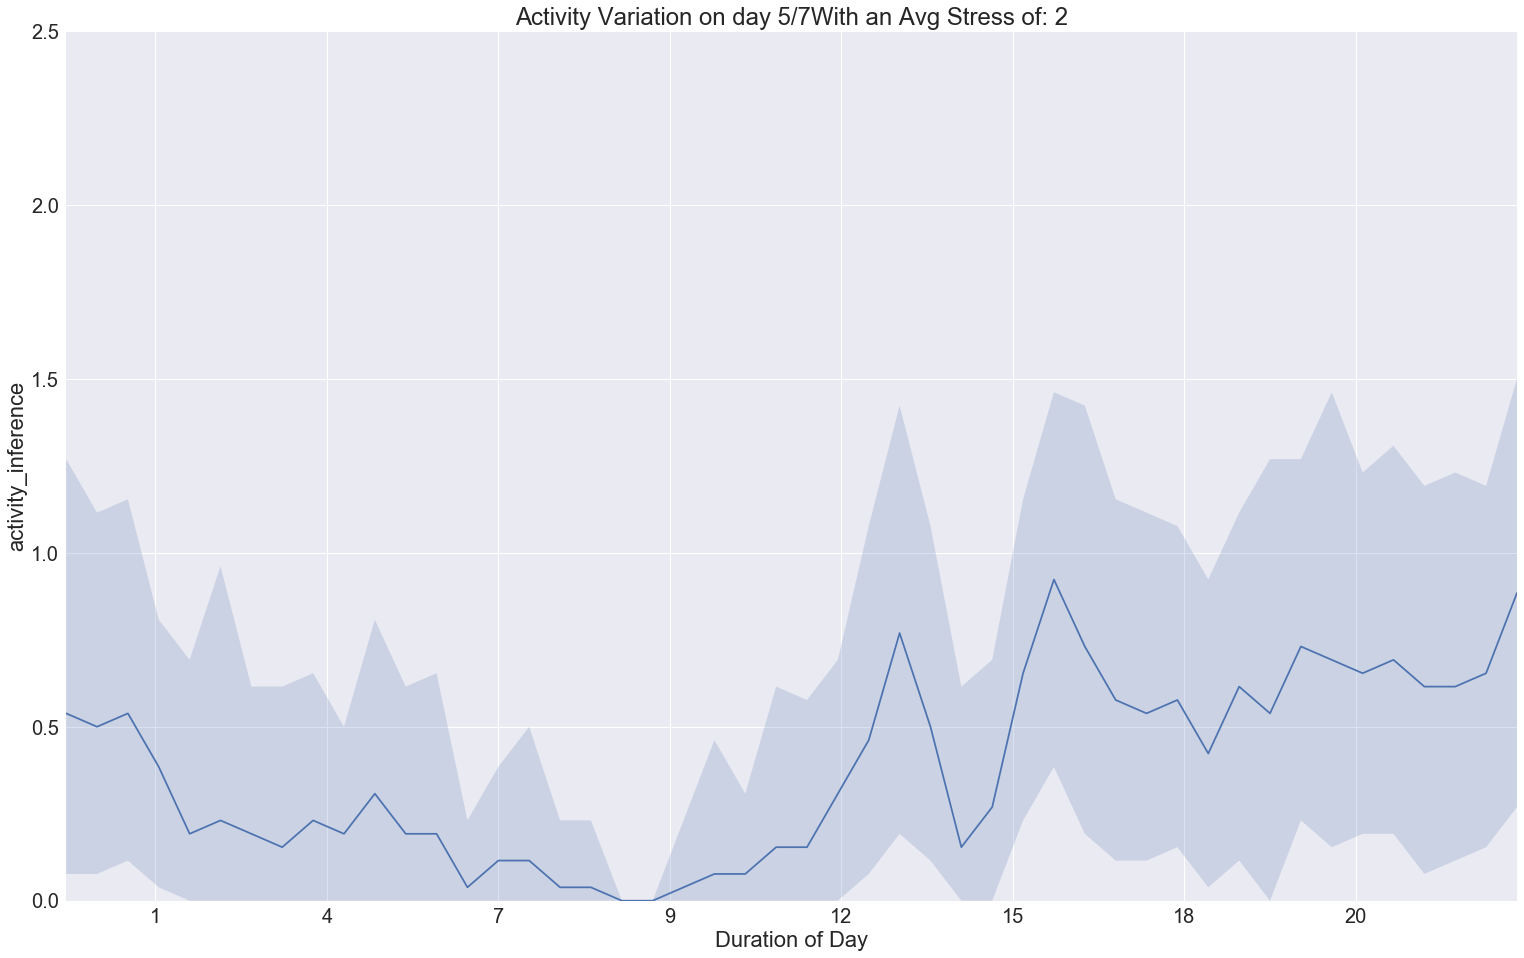

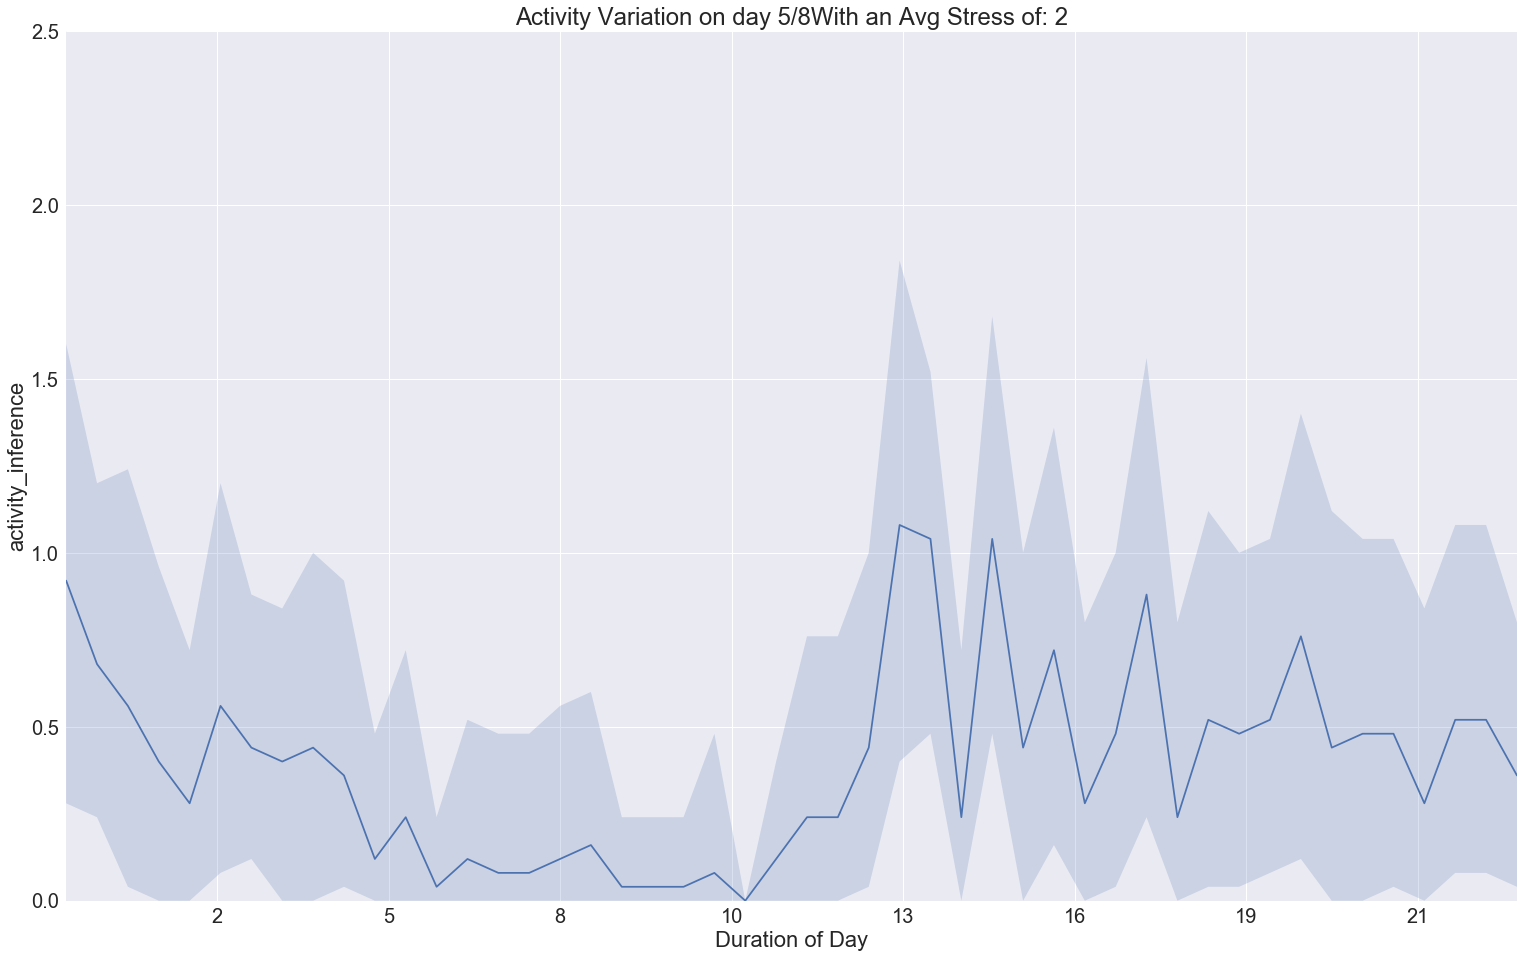

In [53]:
import pandas as pd
import os
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

start_date = datetime.datetime.strptime('24-03-13', '%d-%m-%y')
end_date = datetime.datetime.strptime('08-05-13', '%d-%m-%y')

def myFormatter(x, pos):

    date_f = pd.to_datetime(x, infer_datetime_format=True)
#     print(x, date_f)
    return  str(date_f.hour) 

for day_offset in range(4,46):
    
    # Least stressed day
    stress_day =  start_date + datetime.timedelta(days=day_offset)

    os.chdir('F:\Projects\DataProcessor\StudentLife Data')

    dir_list  = [folder for folder in  os.listdir() if 'student' in folder ]  

    activity_details_final = pd.DataFrame()


    for folder in dir_list:    

        file_name = folder+"\\activity_details_train_x.csv"

        if os.path.exists(file_name):
            activity_details = pd.read_csv(file_name, index_col=0, infer_datetime_format=True, parse_dates=[1])
        else:
            continue
        
        bool_1 =  activity_details['time']  < stress_day + datetime.timedelta(days=1)
        bool_2 =  activity_details['time']  >= stress_day 

        activity_details = activity_details[np.logical_and(bool_1, bool_2)]
        activity_details = activity_details[activity_details['activity_inference'] != 3]
        activity_details = activity_details.loc[:,['time','activity_inference', 'student_id']]


        activity_details_gen = activity_details.groupby(pd.Grouper(key='time', freq='30T')).max()
        activity_details_gen.reset_index(inplace=True)
        activity_details_gen.reset_index(inplace=True)
        
        if len(activity_details_gen) < 48:
            continue

        activity_details_final = activity_details_final.append(activity_details_gen, ignore_index=True) 
        

    activity_details_final['unit'] = activity_details_final.groupby('time').cumcount()+1
    activity_details_final.fillna(value = 0, inplace=True)
    
    #Extracting avg stress on all student that day.
    avg_stress = stress_level[stress_level["date"] == stress_day]['avg_stress_level']
    avg_stress = avg_stress.values[0]
    
    # Plotting the values.
    fig, ax = plt.subplots(figsize=(26,16))
    sns.set(font_scale = 2)
    ax = sns.tsplot(data=activity_details_final, time='time', value='activity_inference',  unit='unit', ci=[100], ax=ax)
    ax.set_ylim((0,2.5))
#     ax.set_xlim((0,24))
    ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(myFormatter))
    ax.set_title("Activity Variation on day "+str(stress_day.month) +"/"+str(stress_day.day)+ "With an Avg Stress of: "+ str(avg_stress))
    ax.set_xlabel('Duration of Day')
    plt.savefig("F:\\Projects\\StudentLife-ML-Analysis\\Vizualization\\Plots\\ActivityViz\\activity_viz_all_studs_day_"+  str(day_offset)  +".jpg")